<h1 style="text-align:center;text-decoration: underline">Astronomy 680 Project #4</h1>

Prof. Rubin/Quimby <br>
Fall 2021 <br>
Joseph Soliz <br>
ID: 825892425 <br>
**Due November 30 at 2pm**

## Background:

It can be said that astronomical research is focused on the study of objects that are simply too far away for us to visit. This means we cannot collect physical samples of our objects and bring them back for study in a laboratory setting. Astronomers must rely on messengers, such as photons, which travel from these distant sources to our observatories on and near Earth. Fortunately, these messengers can reveal a wealth of information. We can determine the temperature, composition, and line-of-sight velocity to high precision by passively collecting the photons of light that come our way and paying close attention to how the flux densities change with wavelength (i.e. spectroscopy).

The [10-m Keck-I telescope](http://www.keckobservatory.org/about/telescopes-instrumentation/) is one of the largest optical/IR telescopes in the world. It has several instruments including a low-resolution imaging spectrograph called [LRIS](https://www2.keck.hawaii.edu/inst/lris/pre_observing.html). Like other major facilities, most data is made public after a proprietary period (usually 1-2 years). These data can be searched and retrieved using the [Keck Observatory Archive (KOA)](https://www2.keck.hawaii.edu/koa/public/koa.php)

## Assignment:

Use spectroscopic data from the Keck archive to measure the redshift of a supernova's host galaxy.

### Targets assignments

|SN Name    | Student           |
| ---       | ---      |
| 2005ir    | Ashley, Rohan   |
| 2005la    | Benjamin, Samantha |
| 2005nb    | Christopher, Spencer    |
| 2006eb    | Joseph, Victoria     |
| 2007sw    | Leo    |
| 2008bj    | Leslie    |
| 2008by    | Michael   |


In [1]:
# name of your target (e.g. "2006gy")
name = "2006eb"

## Process

In [2]:
# some imports you may need
import os
import numpy as np
from glob import glob
from numpy import ma
from astropy.io import fits
from astropy.stats import sigma_clip
from scipy.interpolate import interp1d
from scipy.interpolate import LSQBivariateSpline, LSQUnivariateSpline
from scipy.optimize import fmin
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

import pickle

%matplotlib inline
import matplotlib.pylab as plt

In [3]:
# change plotting defaults
plt.rc('axes', labelsize=14)
plt.rc('axes', labelweight='bold')
plt.rc('axes', titlesize=16)
plt.rc('axes', titleweight='bold')
plt.rc('font', family='sans-serif')
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True

In [4]:
# this is a helper function to display images in this notebook
def show_image(image, lower=-1, upper=3, extent=None):
    sample = sigma_clip(image)
    vmin = sample.mean() + lower * sample.std()
    vmax = sample.mean() + upper * sample.std()
    plt.figure(figsize=(15, 3))
    plt.imshow(image, origin='lower', cmap='gray', aspect='auto', vmin=vmin, vmax=vmax, extent=extent)
    plt.xlabel('Column Number')
    plt.ylabel('Row Number');

# Step 0: Get the data and do initial processing

### Step 0.1: Get the Keck/LRIS data from the Keck Observatory Archive (or sirius)

You can either obtain the data for this project from `sirius.sdsu.edu:/data/astr680/LRIS/` or directly from the [Keck Observatory Archive (KOA)](https://www2.keck.hawaii.edu/koa/public/koa.php).

The objects were all observed over two nights in early 2010. You can use [this link](https://koa.ipac.caltech.edu/cgi-bin/bgServices/nph-bgExec?bgApp=/KOA/nph-KOA&instrument_lr=lris&daterange=20100108-20100109&filetype=both) to query the KOA archive for all data taken on these nights. KOA will list for you the details of each exposure. You can use this information to identify your data and the calibration files you will need to properly process the data. In particular, KOA provides ASCII tables that include the details of each exposure. Copies of these tables are provided in this repo (`sci_lr_5058.tbl.txt` and `cal_lr_5058.tbl.txt`).

For this project, you will need the red channel data (`instrume == 'LRIS'`, *not* `LRISBLUE`), and you will need only the spectroscopic data taken with the [831/8200 grating](https://www2.keck.hawaii.edu/inst/lris/dispersive_elements.html) in `DUAL:L+R` amplifier mode with 2x1 binning on the CCD. Also note that the data are read out using multiple amplifiers (2 in dual mode), and these are each stored in separate FITS extensions. You will want to use the image data in the second extension in each FITS.

Download all the data you will need and, as usual, make sure not to include these files in your repo.

In [5]:
# base directory that contains the `cal` and `sci` subdirectories
basedir = os.path.expanduser('C:/Users/jjuni/OneDrive/Documents/SDSU/Fall2021/Astr680/data/LRIS/') 

# directory with the raw calibration images
caldir = os.path.join(basedir, 'cal/')

# directory with the raw science images
scidir = os.path.join(basedir, 'sci/')

In [6]:
# load the KOA tables
from astropy.table import Table
tcal = Table.read('cal_lr_5058.tbl.txt', format='ascii')
tsci = Table.read('sci_lr_5058.tbl.txt', format='ascii')

In [7]:
# keep only the rows in the calibration image table (`tcal`)
# with the correct instrument setup as defined above
w = (tcal['instrume'] == 'LRIS') & (tcal['binning'] == '2,1')& (tcal['graname'] == '831/8200') & (tcal['ampmode'] == 'DUAL:L+R')#truth array
tcal = tcal[w]
tcal

koaid,ofname,instrument,instrume,object,targname,imagetyp,frameno,ra,dec,date_obs,ut,elaptime,waveblue,wavered,obsmode,equinox,redfilt,blufilt,slitname,dichname,graname,grating,grangle,grisname,binning,window,pane,nvidinp,ampmode,numamps,amplist,ccdgain,ccdspeed,precol,postpix,progid,proginst,progpi,progtitl,filehand,semid,propmin,prop
str22,str17,str4,str8,str15,str13,str9,int32,float64,float64,str10,str11,float64,int32,int32,str7,float64,str5,str5,str8,str3,str8,int32,float64,str8,str3,str17,str17,int32,str8,int32,str7,str4,str6,int32,int32,str6,str4,str7,str46,str52,str12,int32,str1
LR.20100108.10183.fits,r100108_0044.fits,LRIS,LRIS,internal flat,--,arclamp,44,230.0,45.0,2010-01-08,02:49:43.74,1.0,5510,7880,SPEC,2000.0,Clear,clear,long_1.0,560,831/8200,4,0.005,600/4000,"2,1",--,"1500,0,1200,4096",4,DUAL:L+R,4,"4,4,0,0",high,normal,12,80,C269LA,CIT,Quimby,Blindly Selected Supernovae: An Extreme Sample,/koadata25/LRIS/20100108/lev0/LR.20100108.10183.fits,2009b_c269la,18,f
LR.20100108.16047.fits,r100108_0060.fits,LRIS,LRIS,arc lamps,unknown,arclamp,60,230.0,45.0,2010-01-08,04:27:27.43,1.0,5510,7880,SPEC,2000.0,Clear,clear,long_1.0,560,831/8200,4,0.005,600/4000,"2,1",--,"1500,0,1200,4096",4,DUAL:L+R,4,"4,4,0,0",high,normal,12,80,C269LA,CIT,Quimby,Blindly Selected Supernovae: An Extreme Sample,/koadata25/LRIS/20100108/lev0/LR.20100108.16047.fits,2009b_c269la,18,f
LR.20100108.16393.fits,r100108_0061.fits,LRIS,LRIS,arc lamps,Feige110,arclamp,61,349.99329,-5.1655,2010-01-08,04:33:13.43,1.0,5510,7880,SPEC,2000.0,Clear,clear,long_1.0,560,831/8200,4,0.005,600/4000,"2,1",--,"1500,0,1200,4096",4,DUAL:L+R,4,"4,4,0,0",high,normal,12,80,C269LA,CIT,Quimby,Blindly Selected Supernovae: An Extreme Sample,/koadata25/LRIS/20100108/lev0/LR.20100108.16393.fits,2009b_c269la,18,f
LR.20100108.38235.fits,r100108_0087.fits,LRIS,LRIS,G191B2B,G191B2B,arclamp,87,76.3775,52.83222,2010-01-08,10:37:15.81,1.0,5510,7880,SPEC,2000.0,Clear,clear,long_1.0,560,831/8200,4,0.005,600/4000,"2,1",--,"1500,0,1200,4096",4,DUAL:L+R,4,"4,4,0,0",high,normal,12,80,C269LA,CIT,Quimby,Blindly Selected Supernovae: An Extreme Sample,/koadata25/LRIS/20100108/lev0/LR.20100108.38235.fits,2009b_c269la,18,f
LR.20100108.58547.fits,r100108_0129.fits,LRIS,LRIS,lamps,BD+332642,arclamp,129,237.99942,32.94861,2010-01-08,16:15:47.93,1.0,5510,7880,SPEC,2000.0,Clear,clear,long_1.0,560,831/8200,4,0.005,600/4000,"2,1",--,"1500,0,1200,4096",4,DUAL:L+R,4,"4,4,0,0",high,normal,12,80,C269LA,CIT,Quimby,Blindly Selected Supernovae: An Extreme Sample,/koadata25/LRIS/20100108/lev0/LR.20100108.58547.fits,2009b_c269la,18,f
LR.20100108.58732.fits,r100108_0130.fits,LRIS,LRIS,lamps,BD+332642,arclamp,130,237.99942,32.94861,2010-01-08,16:18:52.98,1.0,5510,7880,SPEC,2000.0,Clear,clear,long_1.0,560,831/8200,4,0.005,600/4000,"2,1",--,"1500,0,1200,4096",4,DUAL:L+R,4,"4,4,0,0",high,normal,12,80,C269LA,CIT,Quimby,Blindly Selected Supernovae: An Extreme Sample,/koadata25/LRIS/20100108/lev0/LR.20100108.58732.fits,2009b_c269la,18,f
LR.20100108.58883.fits,r100108_0131.fits,LRIS,LRIS,internal flats,BD+332642,flatlamp,131,237.99942,32.94861,2010-01-08,16:21:23.13,8.0,5510,7880,SPEC,2000.0,Clear,clear,long_1.0,560,831/8200,4,0.005,600/4000,"2,1",--,"1500,0,1200,4096",4,DUAL:L+R,4,"4,4,0,0",high,normal,12,80,C269LA,CIT,Quimby,Blindly Selected Supernovae: An Extreme Sample,/koadata25/LRIS/20100108/lev0/LR.20100108.58883.fits,2009b_c269la,18,f
LR.20100108.59022.fits,r100108_0132.fits,LRIS,LRIS,internal flats,BD+332642,flatlamp,132,237.99942,32.94861,2010-01-08,16:23:42.08,3.0,5510,7880,SPEC,2000.0,Clear,clear,long_1.0,560,831/8200,4,0.005,600/4000,"2,1",--,"1500,0,1200,4096",4,DUAL:L+R,4,"4,4,0,0",high,normal,12,80,C269LA,CIT,Quimby,Blindly Selected Supernovae: An Extreme Sample,/koadata25/LRIS/20100108/lev0/LR.20100108.59022.fits,2009b_c269la,18,f
LR.20100108.59113.fits,r100108_0133.fits,LRIS,LRIS,internal flats,BD+332642,flatlamp,133,237.99942,32.94861,2010-01-08,16:25:13.13,3.0,5510,7880,SPEC,2000.0,Clear,clear,long_1.0,56

In [8]:
# keep only the rows in the science image table (`tsci`)
# with the correct instrument setup as defined above
w = (tsci['instrume'] == 'LRIS') & (tsci['binning'] == '2,1') & (tsci['graname'] == '831/8200') & (tsci['ampmode'] == 'DUAL:L+R') & (tsci['targname'] == name)
tsci = tsci[w]
tsci

koaid,ofname,instrument,instrume,object,targname,imagetyp,frameno,ra,dec,date_obs,ut,elaptime,waveblue,wavered,obsmode,equinox,redfilt,blufilt,slitname,dichname,graname,grating,grangle,grisname,binning,window,pane,nvidinp,ampmode,numamps,amplist,ccdgain,ccdspeed,precol,postpix,progid,proginst,progpi,progtitl,filehand,semid,propmin,prop
str22,str17,str4,str8,str21,str11,str6,int32,float64,float64,str10,str11,float64,int32,int32,str7,float64,str5,str5,str8,str3,str8,int32,float64,str8,str3,str15,str17,int32,str8,int32,str7,str4,str6,int32,int32,str6,str3,str6,str46,str52,str12,int32,str1
LR.20100108.22195.fits,r100108_0066.fits,LRIS,LRIS,arc lamps,2006eb,object,66,18.42112,-0.10197,2010-01-08,06:09:55.11,400.0,5510,7880,SPEC,2000.0,Clear,clear,long_1.0,560,831/8200,4,0.005,600/4000,"2,1",--,"1500,0,1200,4096",4,DUAL:L+R,4,"4,4,0,0",high,normal,12,80,C269LA,CIT,Quimby,Blindly Selected Supernovae: An Extreme Sample,/koadata25/LRIS/20100108/lev0/LR.20100108.22195.fits,2009b_c269la,18,f
LR.20100108.22669.fits,r100108_0067.fits,LRIS,LRIS,2006eb,2006eb,object,67,18.42112,-0.10206,2010-01-08,06:17:49.27,400.0,5510,7880,SPEC,2000.0,Clear,clear,long_1.0,560,831/8200,4,0.005,600/4000,"2,1",--,"1500,0,1200,4096",4,DUAL:L+R,4,"4,4,0,0",high,normal,12,80,C269LA,CIT,Quimby,Blindly Selected Supernovae: An Extreme Sample,/koadata25/LRIS/20100108/lev0/LR.20100108.22669.fits,2009b_c269la,18,f


### Step 0.2: Identify the overscan columns and write a function to remove overscan

The data will all be in raw format, and you will need to remove the floating bias (overscan). It is not necessary to subtract a master bias as the spatial variations of the bias are minimal. 

From the calibration exposure table, locate a flat field exposure (`imagetyp == 'flatlamp'`). Load the image data from the second extension. Find where the overscan columns are. Note that there may only be 2 good overscan columns in these data! These should give a simple, Gaussian distribution of counts with a mean close to 1000. Keep in mind that overscan can include "prescan" columns before the active area and/or "postscan" columns after the active area.

Next, look at the flat field again to determine the active area.

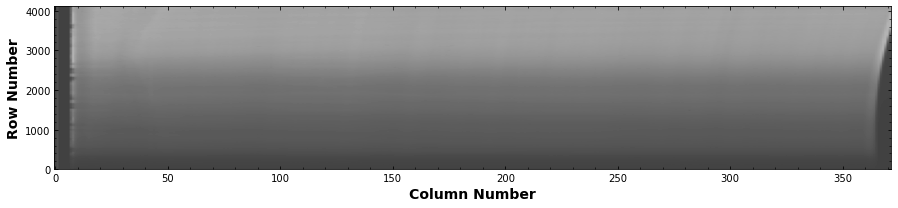

In [9]:
# load and display a raw flat image
flat = fits.getdata(os.path.join(caldir, 'LR.20100108.58883.fits'), ext=2)
show_image(flat)

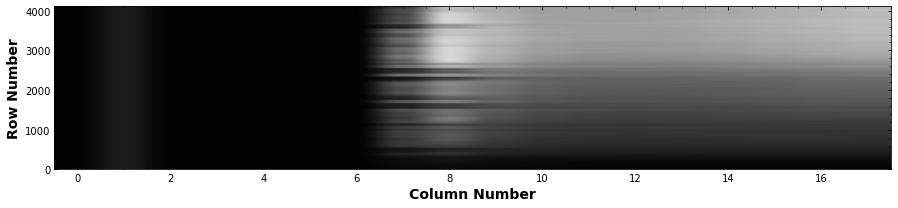

In [11]:
# find the overscan 
# (it may help to plot marginalized profiles)
# asssuming the dark bar in the columns starting at 0 is the overscan
flat2 = show_image(flat[:,0:18]) #zoom in to see overscan

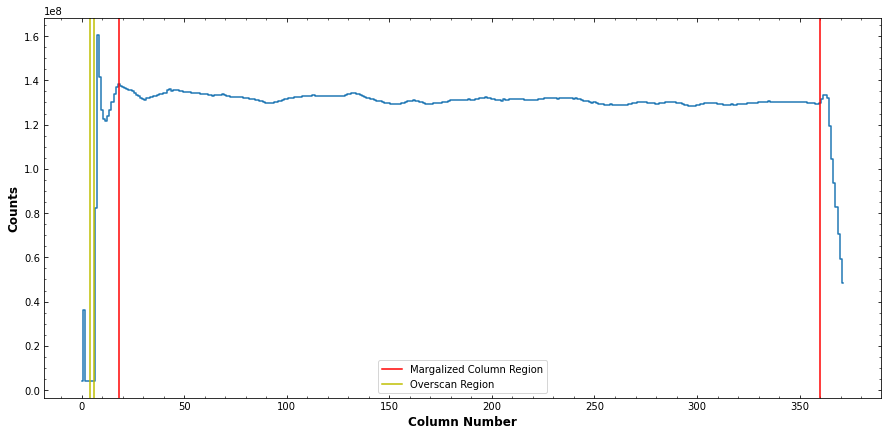

In [12]:
# use a flat to identify the well-illuminated columns
# trim of the edges)
plt.plot(flat.sum(axis=0), drawstyle='steps-mid');
mincol, maxcol = 18, 360
plt.xlabel("Column Number", fontsize=12)
plt.ylabel("Counts", fontsize=12)
plt.axvline(mincol,c='r', label='Margalized Column Region')
plt.axvline(maxcol, c='r')

#overscan in region of 0 to 10
minover, maxover = 4,6
plt.axvline(minover, c='y', label='Overscan Region')
plt.axvline(maxover, c='y')
plt.legend();

1000.3476676384839

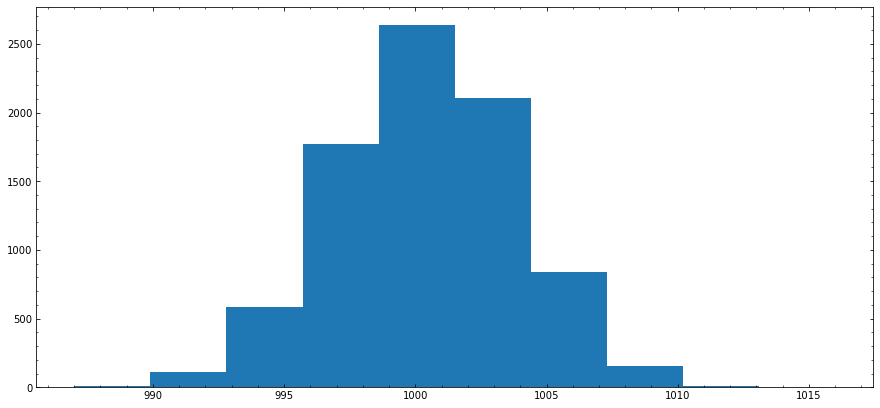

In [13]:
# make sure the overscan count distribution makes sense
plt.hist(flat[:,4:6].flatten())
np.mean(flat[:,4:6])

It would seem the best area where the overscan likely occurs is between column 4 and column 6. The histogram is close to a Guassian distribution and the mean of the two chosen columns is the closest to 1000. 

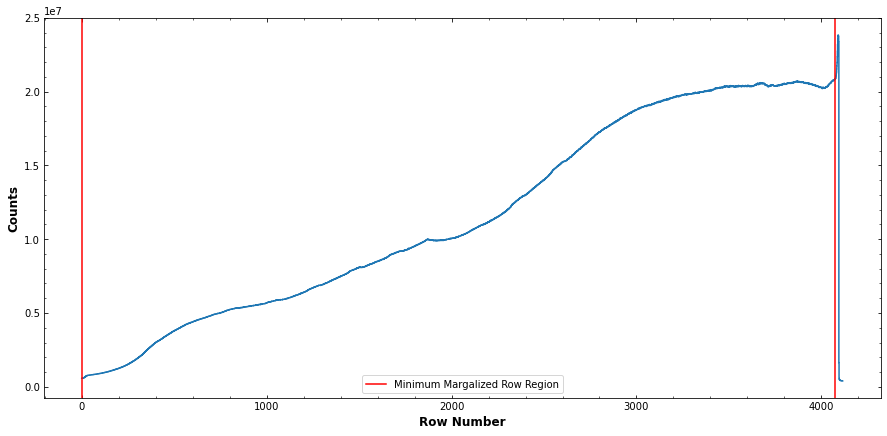

In [14]:
# use a flat to identify the well illuminated rows
plt.plot(flat.sum(axis=1), drawstyle='steps-mid');
minrow, maxrow = 0, 4075
plt.axvline(minrow, c='r', label='Minimum Margalized Row Region')
plt.axvline(maxrow, c='r')
plt.xlabel("Row Number", fontsize=12)
plt.ylabel("Counts", fontsize=12)
plt.legend();

In [15]:
# define slice objects to define the overscan and trim sections of the image data
OVERSCAN_COLS = slice(4, 6)
TRIM_ROWS = slice(minrow, maxrow)
TRIM_COLS = slice(mincol, maxcol)

def remove_overscan(image):
    """
    subtract the mean overscan value, trim, and (for convience) also transpose the image
    
    `image` is a 2D numpy array
    """
    
    overscan = sigma_clip(image[:, OVERSCAN_COLS])
    trim_image = image[TRIM_ROWS, TRIM_COLS] - overscan.mean()
    return trim_image.transpose()
    

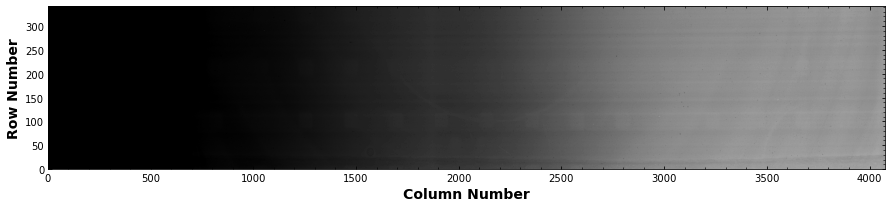

In [16]:
show_image(remove_overscan(flat))

### Step 0.3: Combine (stack) science/calibration frames to remove cosmic rays

If you look at a science exposure, you will notice there are many, many cosmic rays. Each target should have been observed at least twice, which gives you a means to reject these particle events. Use the provided code below to load the data into a data cube, temporarily mask the brightest value recorded for each pixel, determine the expected count distribution for each pixel and then take an average of the full stack with any outliers removed.

In [17]:
def load_images(fnames, ext=2, norm=False):
    # build the data cube
    datacube = None
    for fname in fnames:
        # load the image and remove overscan
        raw = fits.getdata(fname, ext=ext)
        image = remove_overscan(raw)

        if norm:
            image /= np.median(image)
        
        # add to the stack
        image = np.expand_dims(image, axis=0)
        if datacube is None:
            datacube = image
        else:
            datacube = np.vstack((datacube, image))
    return datacube

In [18]:
def imcombine(fnames, nmask=1, norm=False):
    datacube = load_images(fnames, norm=norm)
    
    # convert datacube to a masked data cube (start with everything unmasked)
    mask = np.zeros(datacube.shape)
    masked_cube = ma.masked_array(datacube, mask=mask)

    # mask out the nmask brightest pixels
    j, i = np.indices(datacube.shape[1:])
    if len(fnames) == 1:
        nmask = 0
    for junk in range(nmask):
        wmax = masked_cube.argmax(axis=0)
        masked_cube.mask[wmax, j, i] = True
        
    # locate deviant pixels
    medimage = ma.median(masked_cube, axis=0)
    stdimage = np.std(masked_cube, axis=0)
    pull = np.abs(datacube - medimage) / stdimage
    newmask = pull.data > 5

    # create a new masked array using the new mask (and the same data)
    good_cube = ma.masked_array(datacube, mask=newmask)

    # now take the mean of the good data (for each pixel) ignoring masked values
    return np.mean(good_cube, axis=0).data
    

In [19]:
# path names of the target images
fnames = glob(os.path.join(scidir, "*.fits"))

# combine the images (with cosmic ray rejection)
image = imcombine(fnames)

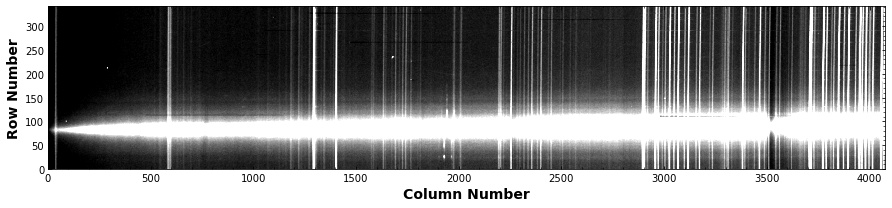

In [20]:
show_image(image)

The science image is the combination of two science spectra of 2006eb as explained in the `tsci` table: LR.20100108.22195.fits and LR.20100108.22669.fits.

Links on information on 2006eb:
- https://www.wis-tns.org/object/2006eb
- https://ui.adsabs.harvard.edu/abs/2006CBET..590....1Q/abstract

The science image shows a very bright object on a single area in the row. As show in the link from Weizmann Interactive Supernova Data Repository (WISeREP), SN 2006eb lies within a bright spiral galaxy. It is likely that the most of the light in the rows is from the galaxy. 

In [21]:
# get the a pixel coordinate near the image center (for later use)
ny, nx = image.shape
cy, cx = ny//2, nx//2

# create 1d arays of the possible x and y values (for later use)
xs = np.arange(nx)
ys = np.arange(ny)

# pixel coordinates for each pixel (for later use)
yvals, xvals = np.indices(image.shape)

## Step 1: Find the (Initial) 1-D Wavelength Solution

Follow the procedure outlined in [Step 1 of the Guide to Long-Slit Spectral Extractions](../tutorials/spectra_guide.ipynb#step1) to determine the initial wavelength solution based on the arclamp exposures.

Note that for Keck/LRIS the wavelength solution changes every time the instrument is reconfigured, so you will want to use arclamp images that were taken in the same batch as your science exposures. For targets, 2005ir, 2006eb, or 2006os you should use the arclamp exposures LR.20100108.16047.fits, LR.20100108.16393.fits, and LR.20100108.38235.fits. For other targets, use LR.20100108.58547.fits and LR.20100108.58732.fits.

### Step 1.0: Set up file paths and combine arc exposures

In [22]:
# choose lamp spectra
if name in ['2005ir', '2006eb', '2006os']:
    lamp_names = ['LR.20100108.16047.fits', 'LR.20100108.16393.fits', 'LR.20100108.38235.fits']
else:
    lamp_names = ['LR.20100108.58547.fits', 'LR.20100108.58732.fits']

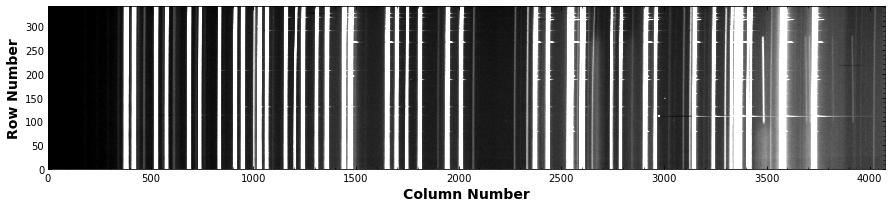

In [23]:
# path names of the arclamp images
fnames = [os.path.join(caldir, lamp_names[i]) for i in range(0,3)]
#in this case, I choosen the first three.

# stack the arclamps
lamp_image = imcombine(fnames)
show_image(lamp_image)

In [24]:
fnames

['C:/Users/jjuni/OneDrive/Documents/SDSU/Fall2021/Astr680/data/LRIS/cal/LR.20100108.16047.fits',
 'C:/Users/jjuni/OneDrive/Documents/SDSU/Fall2021/Astr680/data/LRIS/cal/LR.20100108.16393.fits',
 'C:/Users/jjuni/OneDrive/Documents/SDSU/Fall2021/Astr680/data/LRIS/cal/LR.20100108.38235.fits']

### Step 1.1: Following the spectral guide, extract a lamp spectrum and find precise column centers for each arc lamp line


First is to compare the lamp spectra consist of emission lines from the excited gas in the arc lamps. Use the `line_list.dat` from tutuorials.

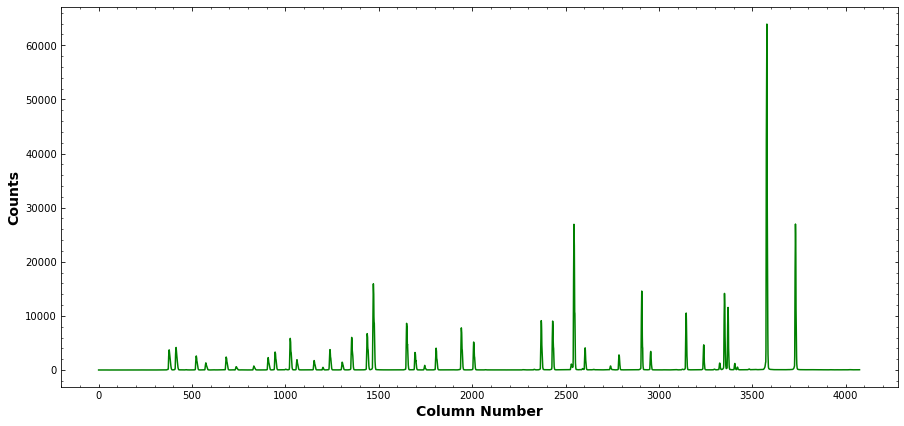

In [25]:
cwd = os.getcwd()
data_dir = os.path.join(cwd, 'C:/Users/jjuni/OneDrive/Documents/SDSU/Fall2021/Astr680/tutorials/media')
dtype = [('wav', float), ('id', 'U2')]
linelist = np.genfromtxt(os.path.join(data_dir, 'line_list.dat'), dtype=dtype)
linelist.sort(order='wav')

# simple average of each column over a few rows
row1 = cy - 5
row2 = cy + 5
lamp_spec = lamp_image[row1:row2, :].mean(axis=0) #0 for column
plt.plot(lamp_spec, c='g')
plt.xlabel('Column Number')
plt.ylabel('Counts');

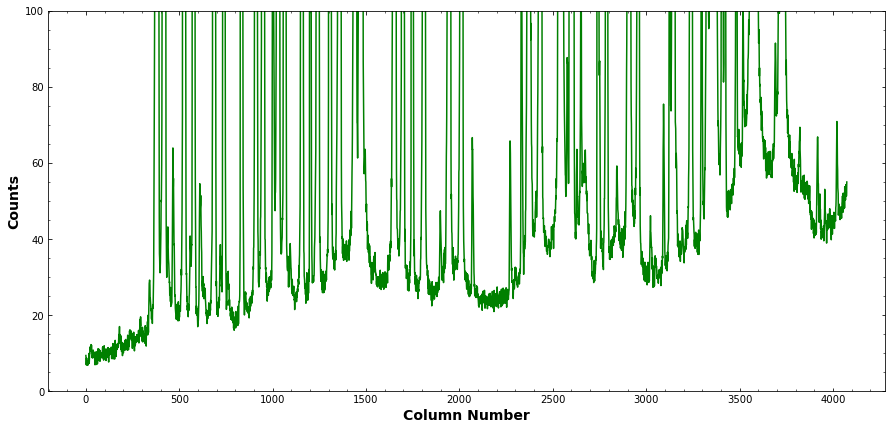

In [26]:
#zoom in to see the noise, shows it's very low
plt.plot(lamp_spec, c='g')
plt.xlabel('Column Number')
plt.ylim(0,100)
plt.ylabel('Counts');

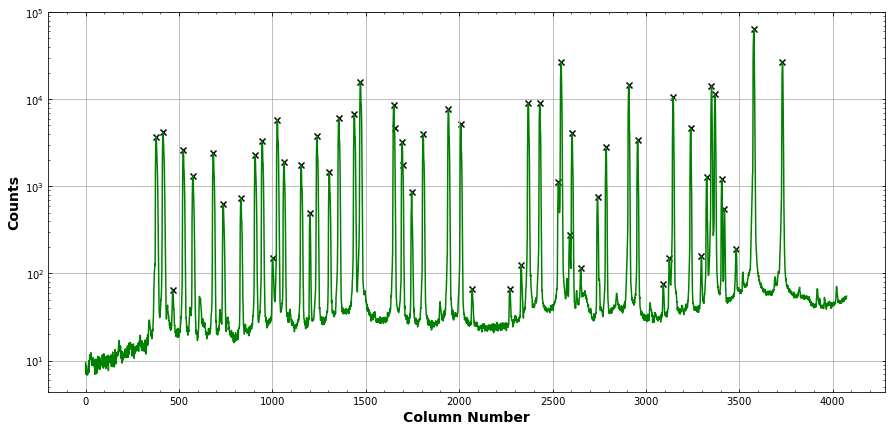

In [27]:
# locate approximate line centers
prominence = 40 #select peaks that are high enough about the noise
peak_cols, properties = find_peaks(lamp_spec, prominence=prominence)

# plot the spectra
plt.plot(lamp_spec, c='g')

# mark the peaks
plt.scatter(peak_cols, lamp_spec[peak_cols], marker='x', c='k')
plt.xlabel('Column Number')
plt.ylabel('Counts')
plt.yscale('log')
plt.grid();
#shows promience in noise primarily 

40 is chosen since it seems to reach the minimum amount for the selected peaks to be above the noise. Prominance 100 was chosen as shown in a draft work of `proj4.specta`, but doesn't seem to make a difference the calculated wavelength.

In [28]:
# use a Gaussian function to model spectral lines
def gaussian(x, *params):
    amp, x0, sigma = params
    return amp * np.exp(-(x - x0)**2 / 2 / sigma**2)

In [29]:
# define a function to determine the precise column centers for each lamp line
def get_lamp_lines(lamp_spec, prominence=40):
    peak_cols, properties = find_peaks(lamp_spec, prominence=prominence)

    # record in a structured array for convenience 
    dtype = []
    dtype.append( ('col', float) )
    dtype.append( ('counts', float) )
    dtype.append( ('x', float) )
    dtype.append( ('y', float) )
    dtype.append( ('sigma', float) )
    dtype.append( ('id', 'U2') )
    dtype.append( ('wav', float) )
    dtype.append( ('wavres', float) )
    dtype.append( ('used', bool) )
    lamp_lines = np.zeros(peak_cols.size, dtype=dtype)
    lamp_lines['col'] = peak_cols
    lamp_lines['counts'] = lamp_spec[peak_cols]
    lamp_lines['x'] = np.nan
    lamp_lines['y'] = np.nan
    lamp_lines['sigma'] = np.nan
    lamp_lines['wav'] = np.nan
    lamp_lines['wavres'] = np.nan

    # fit each peak to determine precise center
    cols = np.arange(lamp_spec.size)
    sigma_guess = 2.5
    for line in lamp_lines:
        if line['counts'] > 60000:
            # line is saturated...skip
            continue

        i0 = max([0, int(line['col'] - 5)])
        i1 = min([lamp_spec.size - 1, int(line['col'] + 5)])
        guess = (line['counts'], line['col'], sigma_guess)
        bounds = ((0, line['col'] - 3, 0), (np.inf, line['col'] + 3, np.inf))
        try:
            popt, pcov = curve_fit(gaussian, cols[i0:i1], lamp_spec[i0:i1], p0=guess, bounds=bounds)
        except RuntimeError:
            # curve_fit failed to converge...skip
            continue

        line['x'] = popt[1]
        line['y'] = gaussian(popt[1], *popt)
        line['sigma'] = popt[2]

    # filter lamp_lines to keep only lines that were fit
    wasfit = np.isfinite(lamp_lines['x'])
    lamp_lines = lamp_lines[wasfit]
    print('found center pixel values for', lamp_lines.size, 'lines')
    return lamp_lines

In [30]:
# helper function to mark lamp lines with and 'x'
def mark_peaks(plt, lamp_lines, xtype='x', ytype='y', c='k'):
    w = np.isfinite(lamp_lines['wav'])
    if w.sum() > 0:
        plt.scatter(lamp_lines[xtype][w], lamp_lines[ytype][w], c=np.abs(lamp_lines['wavres'][w]), zorder=10)
    if (~w).sum() > 0:
        plt.scatter(lamp_lines[xtype][~w], lamp_lines[ytype][~w], c=c, marker='x')

found center pixel values for 54 lines


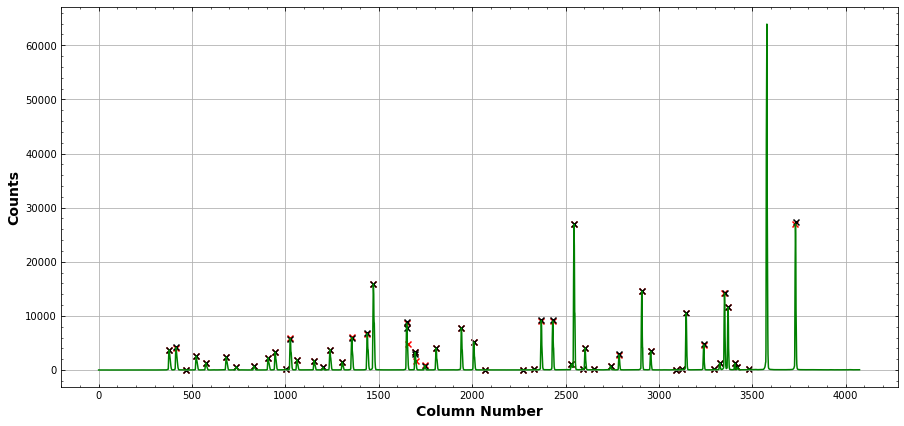

In [31]:
# find the precise column centers for all lamp lines
lamp_lines = get_lamp_lines(lamp_spec, prominence=prominence)

# plot the lamp spectra
plt.plot(lamp_spec, c='g')
plt.xlabel('Column Number')
plt.ylabel('Counts')
plt.grid()

# mark initial values from find_peaks in red
mark_peaks(plt, lamp_lines, 'col', 'counts', c='r')

# mark best-fit values
mark_peaks(plt, lamp_lines)

#you have the peaks from found_peaks in red, a fitted peaks in black 

In [34]:
lamp_lines['col']

array([ 378.,  415.,  466.,  523.,  574.,  683.,  737.,  831.,  908.,
        945., 1001., 1026., 1062., 1154., 1201., 1239., 1304., 1355.,
       1438., 1471., 1649., 1654., 1694., 1699., 1746., 1807., 1942.,
       2008., 2069., 2271., 2332., 2370., 2431., 2531., 2545., 2591.,
       2605., 2651., 2741., 2786., 2908., 2956., 3093., 3125., 3146.,
       3240., 3297., 3325., 3351., 3370., 3406., 3420., 3483., 3731.])

TypeError: only size-1 arrays can be converted to Python scalars

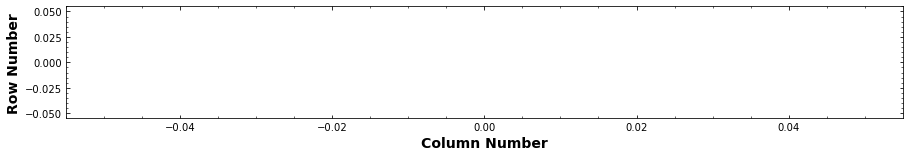

In [33]:
# Check the quality of the Gaussian fits you've made for several (~15-20) 
# of the arc lamp lines
# by overplotting the fitted models to the data.  A handy way to 
# plot a series of many plot panels is to use matplotlib.gridspec.  Be sure 
# you can see the detailed shape of both the lamp line and the Gaussian model
# in each plot panel.

import matplotlib.gridspec as gridspec

fig = plt.figure()
ncol_plt = 5
nrow_plt = 3
gs = gridspec.GridSpec(nrow_plt,ncol_plt)

for row_plt in range(nrow_plt):
    for col_plt in range(ncol_plt): 
        ax = fig.add_subplot(gs[0, :])
        ax.plot(col_plt, row_plt)
        ax.set_xlabel('Column Number')
        ax.set_ylabel('Row Number')
        
        cols1 = np.arange(lamp_spec.size)
        sigma_guess1 = 2.5
        t0 = max([0, int(lamp_lines['col'] - 5)])
        t1 = min([lamp_spec.size - 1, int(lamp_lines['col'] + 5)])
        guess1 = (lamp_lines['counts'], lamp_lines['col'], sigma_guess1)
        bounds1 = ((0, lamp_lines['col'] - 3, 0), (np.inf, lamp_lines['col'] + 3, np.inf))
        popt1, pcov1 = curve_fit(gaussian, cols1[t0:t1], lamp_spec[t0:t1], p0=guess1, bounds=bounds1)
        lamp_lines['x'] = popt1[1]
        lamp_lines['y'] = gaussian(popt1[1], *popt1)
        lamp_lines['sigma'] = popt1[2]
        #used a Boolean slice of the lamp_lines array corresponding to a given unique column value for 
        #each of the 15 subplots, then used the corresponding parameters to compute a Gaussian plot 
        #across x values 5*sigma away from the central column in either direction, then plotted this over 
        #the lamp spectrum in that same column range
        


### Step 1.2: Following the spectral guide, generate a 1st order wavelength solution.  

Note that the instrument setup for these data differ from the example provided in the spectral guide, so you will need to make some minor adjustments. For starters, the wavelength range for these data runs from a bit over 5500 Angstrom to a little less than 8000 Angstrom. By the time you complete your fitting process, you should be able to match around 40 lamp lines and obtain a best-fit residual of less than 0.1 Angstrom. 

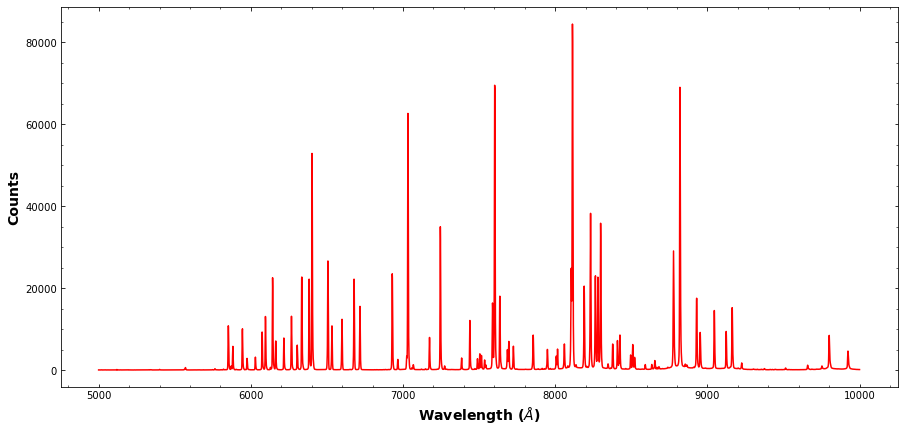

In [35]:
# load and plot the provided spectral atlas
lamp_ref = np.genfromtxt(os.path.join(data_dir, 'lamp_reference.dat'), names='wav, counts')
plt.plot(lamp_ref['wav'], lamp_ref['counts'], c='r')
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Counts');

#this is wavelength calibrated spectra of the lamp

In [36]:
# this function will be used below to match a given line to a given list
def match_to_list(listing, values, plt=None, tol=None, revcoeff=None, c='k'):
    matched = []
    cols = []
    for value in values:
        absdiff = np.abs(value - listing)
        ind = np.argmin(absdiff)
        if tol is None:
            bestmatch = listing[ind]
        elif absdiff[ind] < tol:
            bestmatch = listing[ind]
        else:
            bestmatch = np.nan
        matched.append(bestmatch)

        if plt is not None:
            plt.axvline(bestmatch, ls='dotted', c=c)
            
        if revcoeff is not None:
            col = np.polyval(revcoeff, bestmatch)
            cols.append(col)
            print(f"{bestmatch:.1f} is expected near column {col:.0f}")

    if revcoeff is not None:
        return np.array(matched), cols
    
    return np.array(matched)

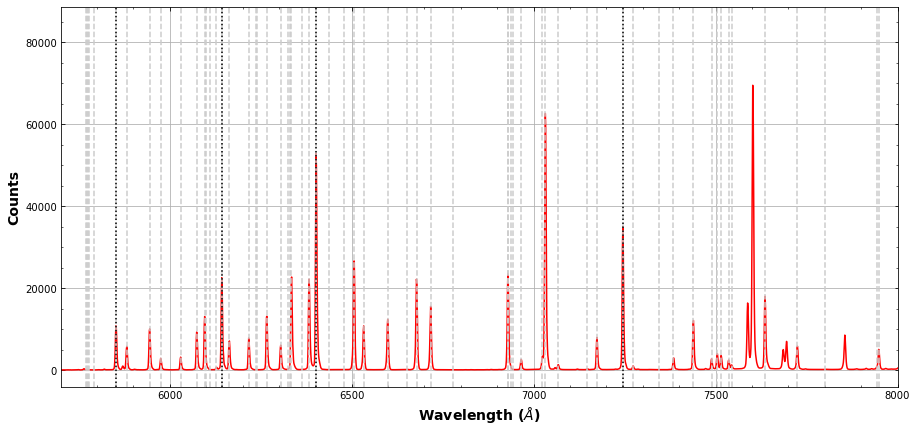

In [37]:
wav1 = 5700
wav2 = 8000

# plot the reference spectrum in red
plt.plot(lamp_ref['wav'], lamp_ref['counts'], label='reference', c='r')
plt.xlim(wav1, wav2)
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Counts'); plt.grid();

# mark all wavelengths available in linelist
for row in linelist:
    plt.axvline(row['wav'], ls='dashed', c='0.8')

# pick a few lines in this plot
rough_waves = [5850, 6150, 6400, 7250] # <---- add a few values here 
refwavs = match_to_list(linelist['wav'], rough_waves, plt=plt)



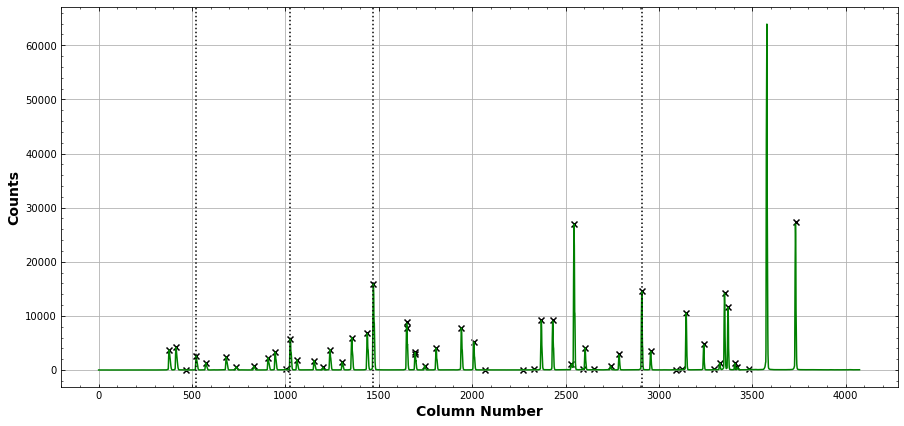

In [38]:
# find a section of lamp_spec that looks similar
col1 = 300
col2 = 2000
plt.plot(lamp_spec, c='g')
#plt.xlim(col1, col2)
plt.xlabel('Column Number'); plt.ylabel('Counts'); plt.grid()

# mark lines with Gaussian-fit centers
mark_peaks(plt, lamp_lines)

# record the rough column numbers of the same lines as above in the same order
rough_cols = [510, 1025, 1475, 2900] # <---- add rough column values here 
refcols = match_to_list(lamp_lines['x'], rough_cols, plt=plt)

#pick the lines that match here with the one above

In [39]:
#records lines
def set_line_identity(lamp_lines, linelist, x, wav):
    # find the closest matching lamp_line
    ilamp = np.argmin(np.abs(lamp_lines['x'] - x))
    
    # find the closest matching row in the linelist
    ilist = np.argmin(np.abs(linelist['wav'] - wav))
    
    # reset values in lamp_lines
    lamp_lines[ilamp]['id'] = linelist[ilist]['id']
    lamp_lines[ilamp]['wav'] = linelist[ilist]['wav']

In [40]:
# record ids and wavelengths of matched lines
for col, wav in zip(refcols, refwavs):
    set_line_identity(lamp_lines, linelist, col, wav)

In [41]:

def get_wavelength_solution(lamp_lines, order=4):
    wfit = np.isfinite(lamp_lines['wav'])
    
    # define the reverse mapping (wavelength to column)
    revcoeff = np.polyfit(lamp_lines['wav'][wfit], lamp_lines['x'][wfit], order)

    # define the forward mapping (column to wavelength)
    coeff = np.polyfit(lamp_lines['x'][wfit], lamp_lines['wav'][wfit], order)
    
    # check the fit for outliers
    fit_wav = np.polyval(coeff, lamp_lines['x'])
    wavres = fit_wav - lamp_lines['wav']
    lamp_lines['wavres'] = wavres
    sample = wavres[wfit]
    sample.sort()
    sample = sample[int(0.1 * sample.size) : int(0.9 * sample.size + 0.5)]    
    std = np.std(sample, ddof=1)
    w = wfit 
    w[wfit] = (np.abs(lamp_lines['wavres'][wfit]) < (5 * std))
    if w.sum() != lamp_lines.size:
        # re-fit with outliers rejected
        coeff, revcoeff = get_wavelength_solution(lamp_lines[w], order=order)
        
        # reset wavelength residuals using new coefficients
        fit_wav = np.polyval(coeff, lamp_lines['x'])
        wavres = fit_wav - lamp_lines['wav']
        lamp_lines['wavres'] = wavres
        
    lamp_lines['used'] = w
    return coeff, revcoeff
        
def check_wavelength_solution(lamp_spec, lamp_lines, coeff):    
    wavs = col_to_wav(coeff, np.arange(lamp_spec.size))
    plt.plot(wavs, lamp_spec, c='g', lw=2)
    mark_peaks(plt, lamp_lines, 'wav')
    plt.colorbar(label='Residual ($\AA$)')
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Counts')
    plt.grid()
    
def col_to_wav(coeff, cols):
    return np.polyval(coeff, cols)

def wav_to_col(revcoeff, wavs):
    return np.polyval(revcoeff, wavs)

def mark_matched(lamp_lines):
    for line in lamp_lines:
        plt.axvline(line['wav'], ls='dotted', c='k')

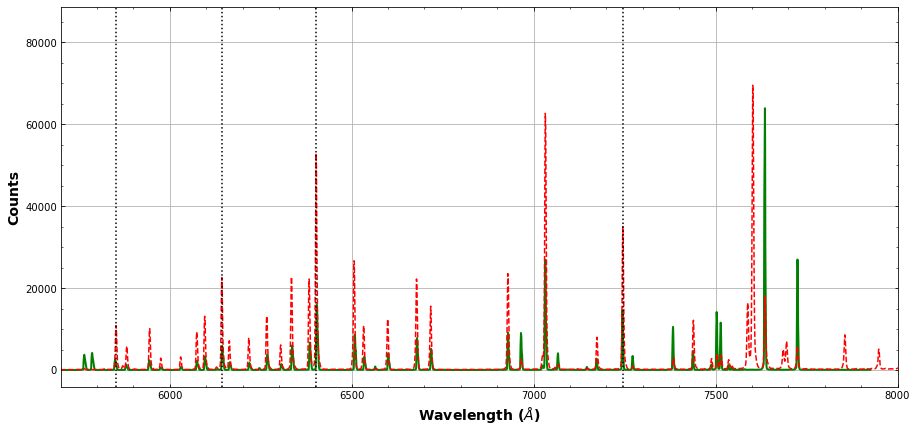

In [42]:
# estimate a linear relation between column number and wavlength
coeff, revcoeff = get_wavelength_solution(lamp_lines, order=1) #first order fit

# apply the wavelength solution to the column numbers
wavs = col_to_wav(coeff, np.arange(lamp_spec.size))

# plot the initial wavelength calibrated spectrum
plt.plot(wavs, lamp_spec, c='g', lw=2, label='lamps')
plt.xlim(wav1, wav2)

# plot the reference spectrum in red
plt.plot(lamp_ref['wav'], lamp_ref['counts'], label='reference', c='r', linestyle='dashed')
plt.xlim(wav1, wav2)
plt.xlabel('Wavelength ($\AA$)'); plt.ylabel('Counts'); plt.grid();
mark_matched(lamp_lines)

In [ ]:
# Check the quality of your 1st order solution by plotting the datapoints 
# you've fit, along with the model

The reference spectra and lamp spectra appear to align with each other.

### Step 1.3: Following the spectral guide, use your 1st order solution to match more lines.

In [43]:
# check for more matches in the range already fit
def match_more(lamp_lines, linelist, order=4, tol=2):
    coeff, revcoeff = get_wavelength_solution(lamp_lines, order=order)
    wfit = np.isfinite(lamp_lines['wav'])
    minwav = lamp_lines['wav'][wfit].min()
    maxwav = lamp_lines['wav'][wfit].max()
    
    xmin = lamp_lines['x'][wfit].min()
    xmax = lamp_lines['x'][wfit].max()
    
    w = (lamp_lines['x'] > xmin) & (lamp_lines['x'] < xmax)
    for line in lamp_lines[w]:
        rough_wav = col_to_wav(coeff, line['x'])
        refwav = match_to_list(linelist['wav'], [rough_wav], tol=tol)
        if np.isfinite(refwav):
            #print(f'matched column {line["x"]:.1f} to wavelength {refwav[0]}')
            set_line_identity(lamp_lines, linelist, line['x'], refwav)
            
match_more(lamp_lines, linelist, order=1)

In [45]:
# Check the quality of these matches by making a two-panel plot of:
# 1. All of the matched datapoints and your linear model
# 2. The wavelength residuals vs. column number
match_more

<function __main__.match_more(lamp_lines, linelist, order=4, tol=2)>

### Step 1.4: Re-fit these matches with a higher order.  

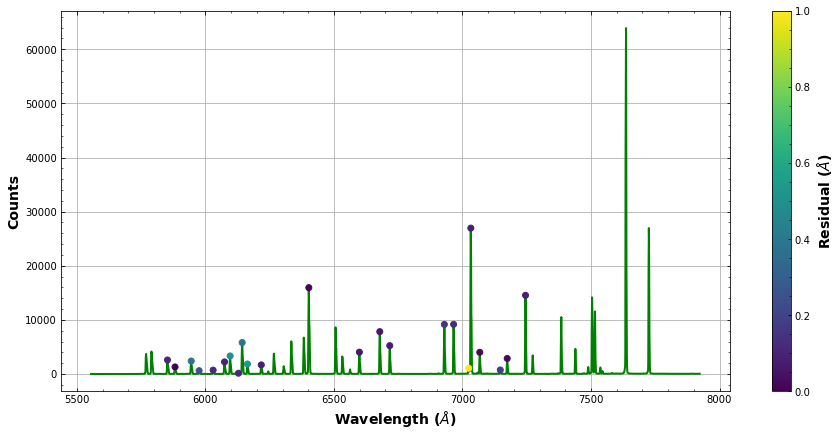

In [46]:
# re-fit with a higher order
coeff, revcoeff = get_wavelength_solution(lamp_lines, order=4)#order is the order of the polynomial fit
check_wavelength_solution(lamp_spec, lamp_lines, coeff)
#dots indicate the lines match and show the residuals
#increase the order will lower the residuals 

5769.6 is expected near column 378
7723.8 is expected near column 3729


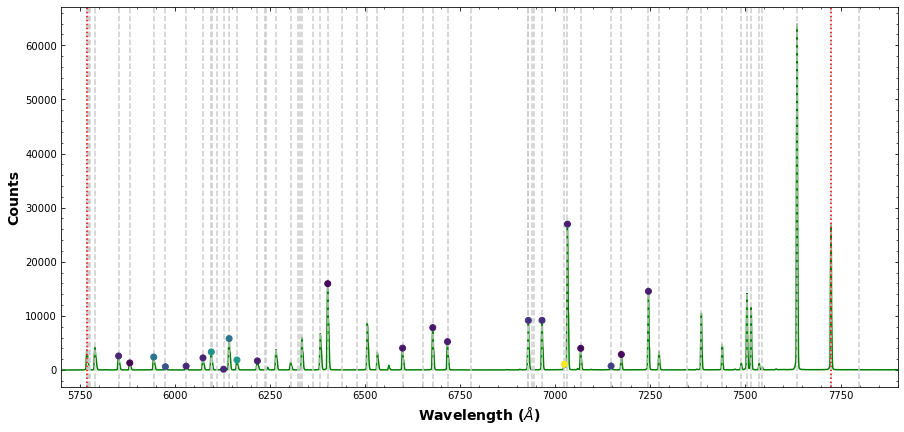

In [47]:

wav1 = 5700
wav2 = 7900

# plot line list over lamp spectra
wavs = col_to_wav(coeff, np.arange(lamp_spec.size))
plt.plot(wavs, lamp_spec, c='g')
plt.xlim(wav1, wav2)

# show available lines in the line list with dashed grey lines
for row in linelist:
    plt.axvline(row['wav'], ls='dashed', c='0.8')

# pick new lines to add
rough_waves = [5750, 7745] # <--- add new lines here
refwavs, rough_cols = match_to_list(linelist['wav'], rough_waves, plt=plt, revcoeff=revcoeff, c='r')
refcols = match_to_list(lamp_lines['x'], rough_cols, plt=plt)

# mark existing matches
mark_peaks(plt, lamp_lines, 'wav')
plt.xlabel('Wavelength ($\AA$)'); plt.ylabel('Counts');

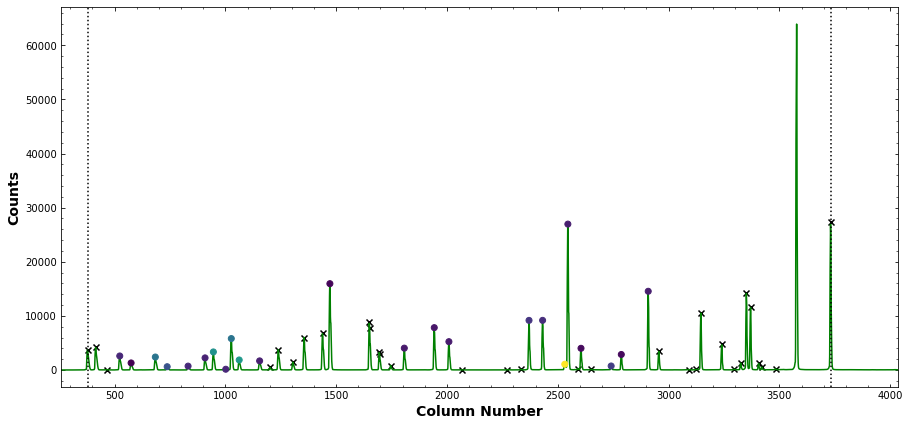

In [48]:
#  Check for improvement in the solution by plotting the wavelength residuals as above
col1, col2 = np.polyval(revcoeff, [wav1, wav2])
refcols = match_to_list(lamp_lines['x'], rough_cols)

plt.plot(lamp_spec, c='g')
mark_peaks(plt, lamp_lines, 'x', 'y')

plt.xlim(col1, col2)
refcols = match_to_list(lamp_lines['x'], rough_cols, plt=plt)
plt.xlabel('Column Number'); plt.ylabel('Counts');

### Step 1.5: Use the revised wavelength solution to extend the range of line matches, if needed.  Use these new matches to re-determine the wavelength solution.

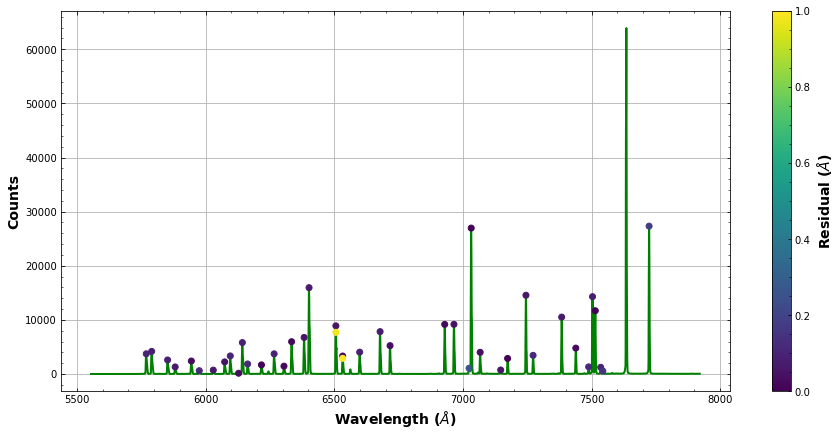

In [49]:
# add new lines to the matches
for col, wav in zip(refcols, refwavs):
    set_line_identity(lamp_lines, linelist, col, wav)
    
# auto-match more lines
match_more(lamp_lines, linelist)

# re-fit
coeff, revcoeff = get_wavelength_solution(lamp_lines, order=4)
check_wavelength_solution(lamp_spec, lamp_lines, coeff)

### Step 1.6: Plot the wavelength residuals for your final solution.  Comment on the quality of the solution.

STD of wavelength residual is 0.059 Angstrom.


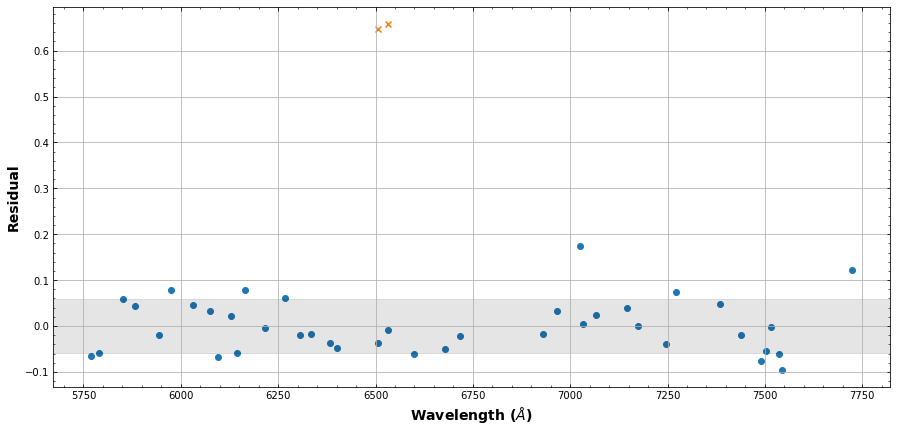

In [50]:
w = lamp_lines['used']
std = np.std(lamp_lines['wavres'][w], ddof=1)
print(f'STD of wavelength residual is {std:0.2} Angstrom.')

plt.scatter(lamp_lines['wav'][w], lamp_lines['wavres'][w])
plt.scatter(lamp_lines['wav'][~w], lamp_lines['wavres'][~w], marker='x')
plt.axhspan(-std, std, color='k', alpha=0.1)
plt.xlabel('Wavelength ($\AA$)'); plt.ylabel('Residual'); plt.grid();

## Step 2: Find the 2-D Wavelength Solution

Follow the procedure outlined in [Step 2 of the Guide to Long-Slit Spectral Extractions](../tutorials/spectra_guide.ipynb#step2) to determine the 2-D wavelength solution based on the skylines in the science exposure.

Some of these targets are large galaxies that extend over a good fraction of the slit. Make sure to mask out this extended light when fitting for the sky background.

### Step 2.0: Start by creating a boolean mask that is True for sky pixels

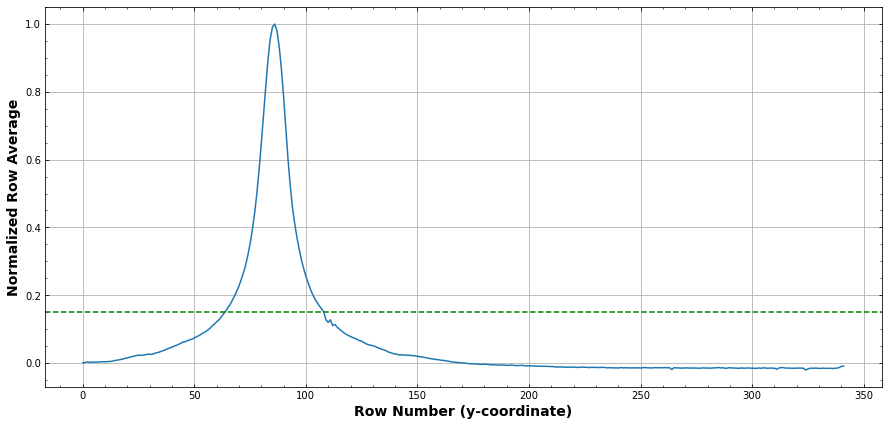

In [51]:
rowaverage = image.mean(axis=1)
rowaverage -= np.median(rowaverage)
rowaverage /= rowaverage.max()
plt.plot(ys, rowaverage)
plt.axhline(0.15, c='g', ls='--')
plt.xlabel('Row Number (y-coordinate)'), plt.ylabel('Normalized Row Average')
plt.grid();

In [52]:
# find the rows with object light
objrows = ys[rowaverage > 0.15] 
#this based on where the peaks seem to average out to start. Basically above the sky level line.

# add some margin to object rows
ngrow = 5 # number of rows to add above and below object rows
newobjrows = []
for row in objrows:
    newobjrows.extend([row + i for i in np.arange(-ngrow, ngrow + 1)])
objrows = np.unique(newobjrows)

# mask to mark sky rows
skymask = np.ones(image.shape, dtype=bool)
skymask[objrows, :] = False

# also exclude bad rows
badrows = ys[rowaverage < -0.05] #based on the normalized row averages in the plot. 
skymask[badrows, :] = False

# rows with mostly sky background light
skyrows = ys[skymask.mean(axis=1) == 1]

In [53]:
# median (unmasked) sky spectrum and standard deviation
medspec = np.median(image[skyrows, :], axis=0)
stdspec = np.std(image[skyrows, :], axis=0, ddof=1)

# exclude deviant pixels from the skymask
pull = (image - medspec) / stdspec
w = pull > 5
skymask[w] = False

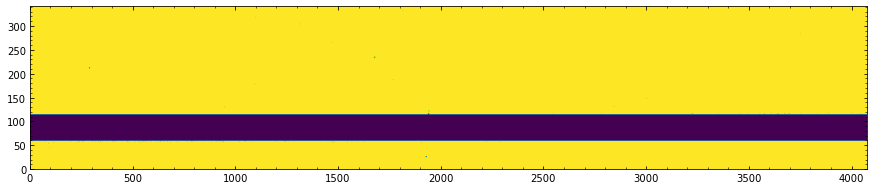

In [54]:
#mask
plt.figure(figsize=(15, 3))
plt.imshow(skymask, origin='lower', aspect='auto');
#yellow is where we include from the sky, purple is what is excluded from the sky
#thin lines are the cosmic rays masked out

### Step 2.1: Then choose a small region of the image to model the change in wavelength as a function of x- and y-offset (`dxs` and `dys` from some reference pixel).

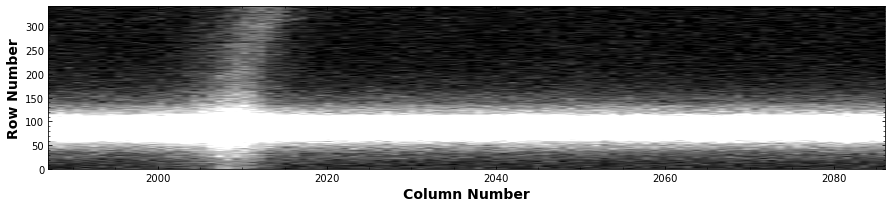

In [55]:
# cut out a small image "stamp" near the center of the frame
row = cy
col = cx
hwidth = 50
stamp = image[:, col - hwidth : col + hwidth]
ys_stamp = yvals[:, col - hwidth : col + hwidth]
xs_stamp = xvals[:, col - hwidth : col + hwidth]

# show the image stamp
extent = (xs_stamp.min(), xs_stamp.max(), ys_stamp.min(), ys_stamp.max())
show_image(stamp, extent=extent);

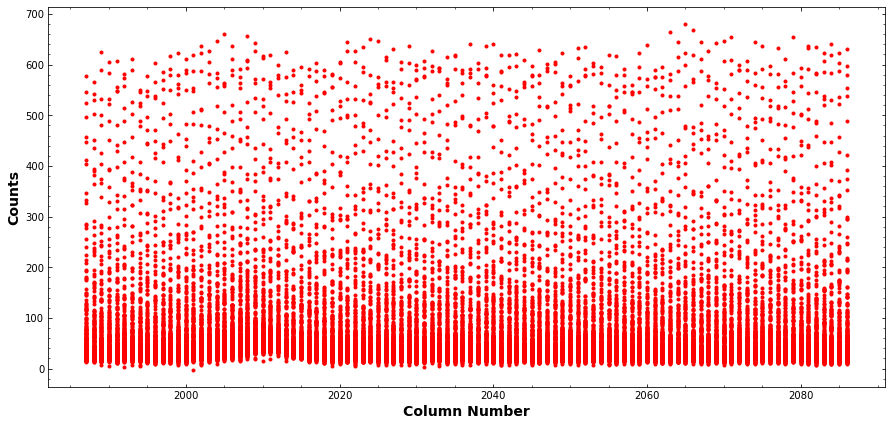

In [56]:
# plot stamp values against column numbers
plt.plot(xs_stamp.ravel(), stamp.ravel(), 'r.');
plt.xlabel('Column Number'), plt.ylabel('Counts');

It appears based on the stamp of the science image, a majority of the counts stays around 50 to 100 while be equally distributed across the column numbers. It beceome more scattered above 150 counts. 

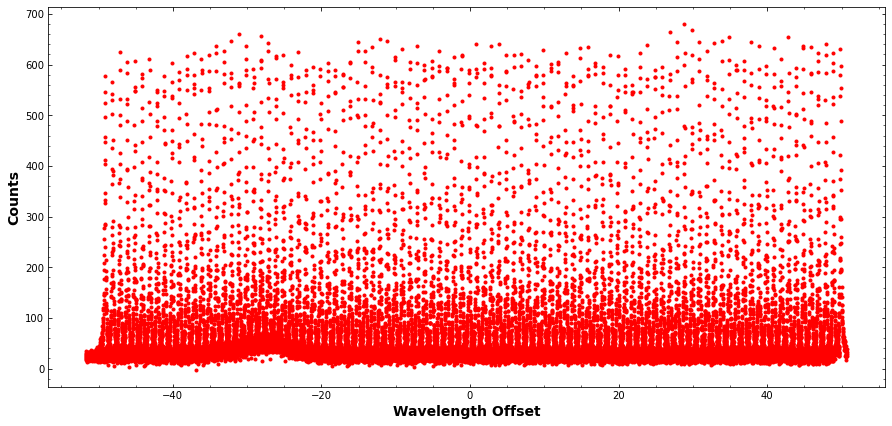

In [57]:
# What are the best-fit values of your model parameters?  
# Do they do a good job of minimizing the scatter in a plot of counts vs. wavelength offset?
def get_dl_model(params, dxs, dys):
    return dxs + params[0] * dys + params[1] * dys ** 2
#retunrs a set parameters that combines x coord with quardratic fn and y coord with quardratic
#returns wavelength oscillate

# pixel offsets from the refernece pixel
dxs = xs_stamp - col
dys = ys_stamp - row

# parameter guess
guess = (-0.01, 0) 
#guesses are parameter values (params[0], params[1])

# get the wavelength offsets and plot vs. counts
dls = get_dl_model(guess, dxs, dys)
plt.plot(dls.ravel(), stamp.ravel(), 'r.')
plt.xlabel('Wavelength Offset')
plt.ylabel('Counts');

Althought the guess was kept at (-0.01, 0), if you increase the guess of parameter[0] with dys to 50 it reveals the wavelength in the model. However, if you run it, the rest of the coding for the spline and the lines crash.

In [58]:
def get_profile_spl(dls, stamp):
    # need to sort the data (and weights) so that the x values are increasing
    x, y = dls.ravel(), stamp.ravel()
    weights = np.sqrt(np.abs(y)) # not technically optimal for coadded data, but ok
    wsort = x.argsort()
    x, y, weights = x[wsort], y[wsort], weights[wsort]

    # set locations for spline knots
    t = np.linspace(x.min() + 1, x.max() - 1, np.int(x.max() - x.min()))
    spl = LSQUnivariateSpline(x, y, t, weights)
    return x, y, spl

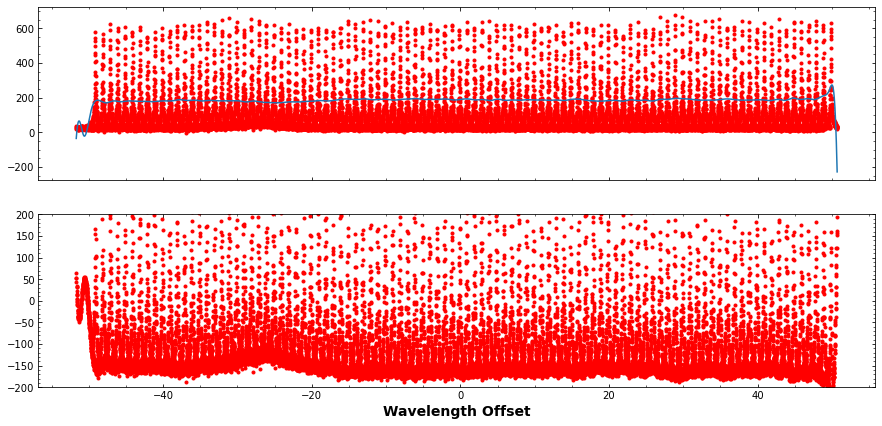

In [59]:
# fit a spline to the data and plot
#spline fit is 
x, y, spl = get_profile_spl(dls, stamp)

fig, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(x, y, 'r.')
axarr[0].plot(x, spl(x))
axarr[1].plot(x, y - spl(x), 'r.')
plt.ylim(-200, 200)
plt.xlabel('Wavelength Offset');

In [60]:
def check_dl_model(params, dxs, dys, stamp):
    dls = get_dl_model(params, dxs, dys)
    x, y, spl = get_profile_spl(dls, stamp)
    chisq = np.sum((stamp - spl(dls)) ** 2 / np.sqrt(np.abs(stamp)))
    return chisq / (stamp.size - len(params))

# see how good our guess is
check_dl_model(guess, dxs, dys, stamp)

3684.7340997045317

In [61]:
# What are the best-fit values of your model parameters?  
# get the best model parameters for this stamp
params = fmin(check_dl_model, guess, args=(dxs, dys, stamp))
print("best model parameters are", params)

Optimization terminated successfully.
         Current function value: 17.384701
         Iterations: 138
         Function evaluations: 328
best model parameters are [-22.57781266   0.02864248]


Do they do a good job of minimizing the scatter in a plot of counts vs. wavelength offset?
- Although there is indication of a peak in the wavelength offset between -40 and -20, there's a lot of scattered light in the stamp. The parameters being -22.5778 and 0.0286 is large.

Trying the parameters for the guess. 

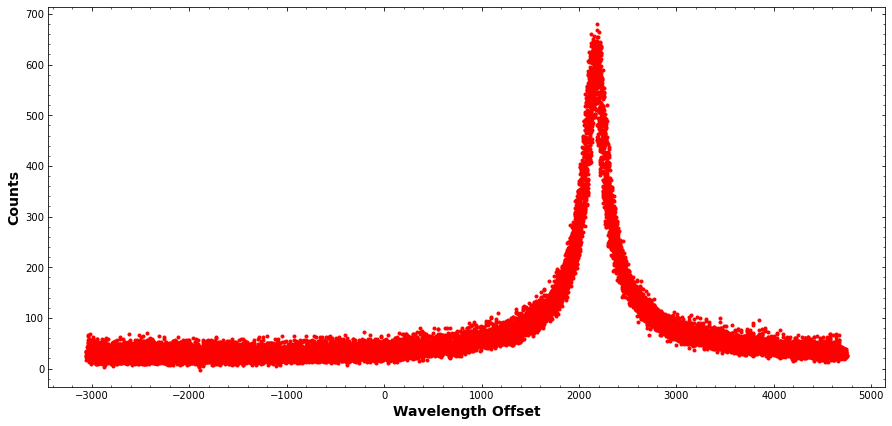

In [62]:
# new parameter guess
guess0 = (-22.57781266, 0.02864248) 
#guesses are parameter values (params[0], params[1])

# get the wavelength offsets and plot vs. counts
dls = get_dl_model(guess0, dxs, dys)
plt.plot(dls.ravel(), stamp.ravel(), 'r.')
plt.xlabel('Wavelength Offset')
plt.ylabel('Counts');

In [63]:
def get_profile_spl(dls, stamp):
    # need to sort the data (and weights) so that the x values are increasing
    x, y = dls.ravel(), stamp.ravel()
    weights = np.sqrt(np.abs(y)) # not technically optimal for coadded data, but ok
    wsort = x.argsort()
    x, y, weights = x[wsort], y[wsort], weights[wsort]

    # set locations for spline knots
    t = np.linspace(x.min() + 1, x.max() - 1, np.int(x.max() - x.min()))
    spl = LSQUnivariateSpline(x, y, t, weights)
    return x, y, spl

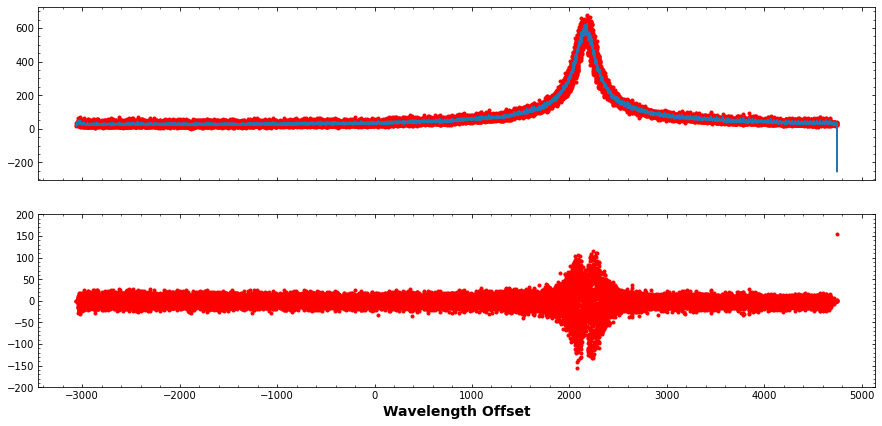

In [64]:
# fit a spline to the data and plot
#spline fit is 
x, y, spl = get_profile_spl(dls, stamp)

fig, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(x, y, 'r.')
axarr[0].plot(x, spl(x))
axarr[1].plot(x, y - spl(x), 'r.')
plt.ylim(-200, 200)
plt.xlabel('Wavelength Offset');

In [66]:
def check_dl_model(params, dxs, dys, stamp):
    dls = get_dl_model(params, dxs, dys)
    x, y, spl = get_profile_spl(dls, stamp)
    chisq = np.sum((stamp - spl(dls)) ** 2 / np.sqrt(np.abs(stamp)))
    return chisq / (stamp.size - len(params))

# see how good our guess is
check_dl_model(guess0, dxs, dys, stamp)

17.974393193848712

In [67]:
params0 = fmin(check_dl_model, guess, args=(dxs, dys, stamp))
print("best model parameters are", params0)

Optimization terminated successfully.
         Current function value: 17.384701
         Iterations: 138
         Function evaluations: 328
best model parameters are [-22.57781266   0.02864248]


Now the $\chi^2$ is smaller to 17.974 with the spline fit more centered to the wavelength offset. However, when using the best model parameters to calculate the lines of the constant wavelength, the coding crashes. It's error is input parameters have been rejected by fpchec. So the intial parameter guess of (-0.01, 0) will have to be used. 

### Step 2.2: Now, do the same thing again, but this time, include only sky pixels when you fit your model.

In [ ]:
# What are your new best-fit values of your model parameters?  
# Do they do a good/better job of minimizing the scatter in a plot of counts vs. wavelength offset?  
# Why or why not?


In [ ]:
# Use your best-fit model to trace out a curve of constant wavelength offset. 
# Overplot this curve on your image stamp.  (You can center the curve anywhere within your stamp.)
# How does the shape of this curve compare to that of the sky lines?
# Does this shape make sense?



### Step 2.3: Find the lines of constant wavelength across the entire 2D image.

In [69]:
# define the column centers for the stamps
hwidth = 200 #full width is 400
cols = np.arange(hwidth, nx, 2 * hwidth)
cols

array([ 200,  600, 1000, 1400, 1800, 2200, 2600, 3000, 3400, 3800])

In [71]:
# reference wavelength offsets to the center row
row = cy

# define a 2D array to hold the wavelength offsets for each pixel
lambdas = np.zeros(image.shape) 

# loop over each central column
for col in cols:
    print('col = ', col)
    
    # slice the data
    inds = np.s_[:, col - hwidth : col + hwidth]
    stamp = image[inds]
    mask = skymask[inds]
    dys = yvals[inds] - row
    dxs = xvals[inds] - col

    # initial fit
    params = fmin(check_dl_model, guess, args=(dxs[mask], dys[mask], stamp[mask]))
    
    # check for outliers
    dls = get_dl_model(guess, dxs, dys)
    x, y, spl = get_profile_spl(dls, stamp)
    model = spl(dls)
    pull = (stamp - model) / np.sqrt(np.abs(model))
    w = (pull < 5) & mask
    params2 = fmin(check_dl_model, params, args=(dxs[w], dys[w], stamp[w]))

    # record
    lambdas[inds] = get_dl_model(params2, dxs, dys) + col

col =  200
Optimization terminated successfully.
         Current function value: 25.254748
         Iterations: 32
         Function evaluations: 61
Optimization terminated successfully.
         Current function value: 25.257338
         Iterations: 8
         Function evaluations: 16
col =  600
Optimization terminated successfully.
         Current function value: 31.813434
         Iterations: 24
         Function evaluations: 47
Optimization terminated successfully.
         Current function value: 31.835998
         Iterations: 7
         Function evaluations: 14
col =  1000
Optimization terminated successfully.
         Current function value: 38.331759
         Iterations: 20
         Function evaluations: 39
Optimization terminated successfully.
         Current function value: 38.366796
         Iterations: 9
         Function evaluations: 16
col =  1400
Optimization terminated successfully.
         Current function value: 41.272648
         Iterations: 19
         Function 

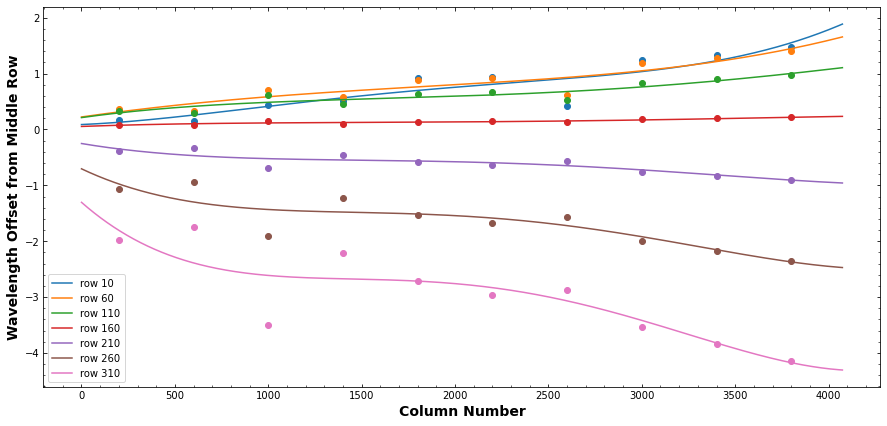

In [72]:
# Look at the results for a few rows and fit a low-order polynomial
order = 4
#order 1 would have them as linear lines
for y in range(10, ny, 50):
    p = plt.plot(cols, lambdas[y, cols] - xs[cols], 'o')
    c = np.polyfit(cols, lambdas[y, cols] - xs[cols], order)
    plt.plot(xs, np.polyval(c, xs), c=p[0].get_color(), label='row {}'.format(y))
plt.legend()
plt.xlabel('Column Number')
plt.ylabel('Wavelength Offset from Middle Row');
#each row is the row on the image

The data on the wavelength offset is more widespread, particularly at the 1000 column. The Lambda fit should fix this.

In [73]:
# Get the lambda values for the entire image (fit)
lambdafit = np.zeros(image.shape)
for y in range(ny):
    c = np.polyfit(cols, lambdas[y, cols] - xs[cols], order)
    lambdafit[y, :] = np.polyval(c, xs) + xs
    
print("The lammbda fit of y is {}.".format(y))

The lammbda fit of y is 341.


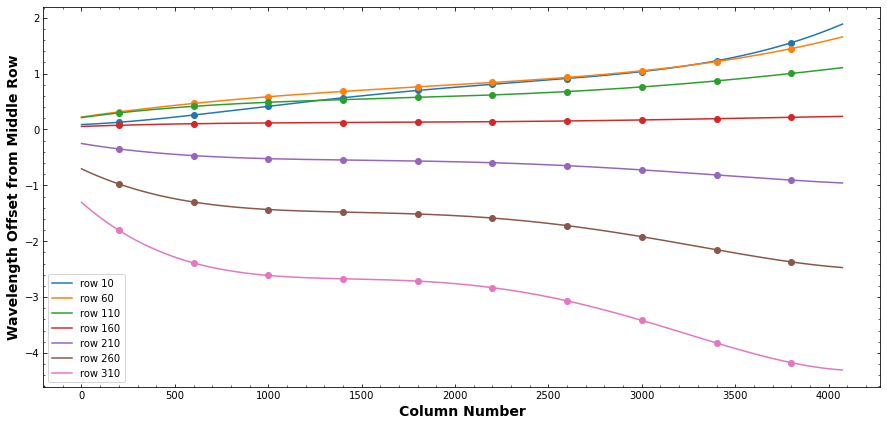

In [74]:
order = 4
#order 1 would have them as linear lines
for y in range(10, ny, 50):
    p = plt.plot(cols, lambdafit[y, cols] - xs[cols], 'o')
    c = np.polyfit(cols, lambdafit[y, cols] - xs[cols], order)
    plt.plot(xs, np.polyval(c, xs), c=p[0].get_color(), label='row {}'.format(y))
plt.legend()
plt.xlabel('Column Number')
plt.ylabel('Wavelength Offset from Middle Row');

## Step 3: Flat Field the 2-D Spectra (Optional)

This step is optional, but you can follow the procedure outlined in [Step 3 of the Guide to Long-Slit Spectral Extractions](../tutorials/spectra_guide.ipynb#step3) to correct the data for flat field variations. 

## Step 4: Model the 2-D Sky

Follow the procedure outlined in [Step 4 of the Guide to Long-Slit Spectral Extractions](../tutorials/spectra_guide.ipynb#step4) to model the 2-D sky background. 

In [75]:
# function to fit a 2D spline
def fit_sky(xvals, yvals, image, ky=1, dx=0.5):
    # select knot points in the x (wavelength) direction
    tx = np.arange(xvals.min() + 2, xvals.max() - 2, dx)
    
    # select knot points in the y (spatial) direction
    ty = [] # if there are no knots, the fit will be a poly nomial of degree ky
    
    # fit the 2D spline
    return LSQBivariateSpline(xvals.ravel(), yvals.ravel(), image.ravel(), tx, ty, ky=ky)

In [76]:
# use the (unmasked) sky background pixels and fit the 2D spline
skyfit = fit_sky(lambdafit[skymask], yvals[skymask], image[skymask])
#inputs are array offsets, lambdafit 

# evaluate the 2D sky at every pixel
sky = skyfit.ev(lambdafit, yvals)

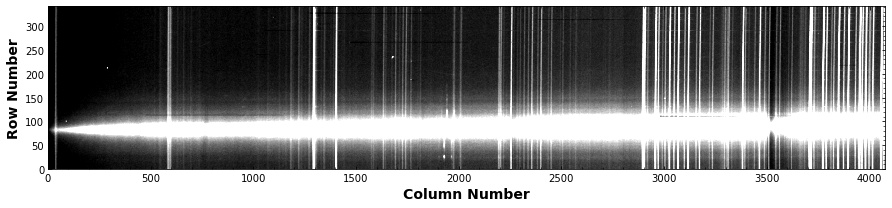

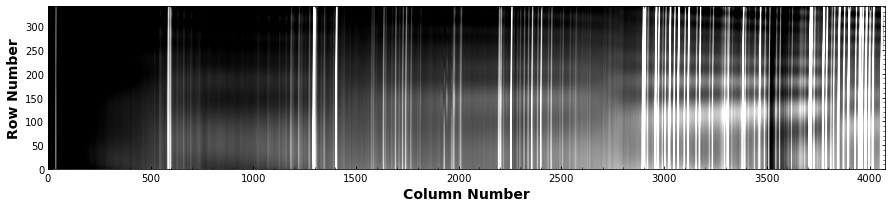

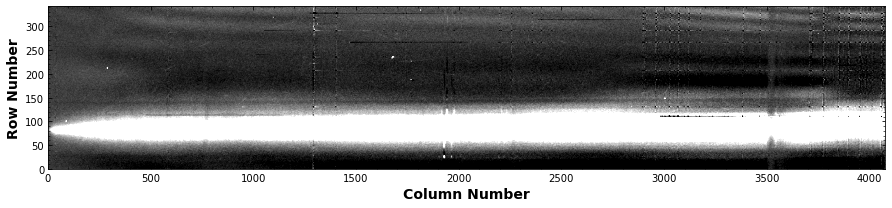

In [67]:
show_image(image)
show_image(sky)
show_image(image-sky)

 Comment on the quality of your sky model.  If needed, how could it be improved?

- Most of the emmission lines from the sky in the science image have been removed. Just the final image looks like it's warped outside the main target row. It could be improved if the images were flatten.

## Step 5: Extract the 1-D Target Spectrum

Follow the procedure outlined in [Step 5 of the Guide to Long-Slit Spectral Extractions](../tutorials/spectra_guide.ipynb#step5) to extract the 1-D target spectrum. 

Give particular consideration to which spatial positions along the slit you wish to extract. You will be using emission lines from the galaxy to measure the redshift, so make sure your extraction aperture includes these features.

### Step 5.0: Generate Gaussian models of the object profile at several different wavelength ranges.

In [77]:
def get_profile_model(params, ys):
    a1, cy1, sigma1 = params
    #a1 is height of Guassian, cy1 row number of the peak, sigma1 is sigma of Guassian
    p1 = np.exp(-(ys - cy1)**2 / 2 / sigma1**2) 
    p1 /= p1.max()

    return a1 * p1 

### Step 5.1: Fit a polynomial to the center of the object trace.

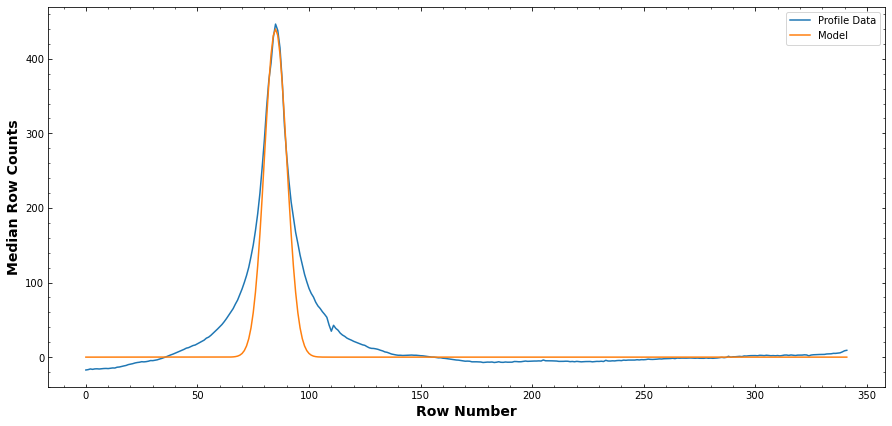

In [78]:
# get the median for each row
profile = np.median(image - sky, axis=1)

# starting guess for the profile model
guess = (440, 85, 5.0) #amp, x0(row), sigma
model = get_profile_model(guess, ys)

plt.plot(ys, profile, label='Profile Data')#blue line
plt.plot(ys, model, label='Model'); #orange line
plt.xlabel('Row Number')
plt.ylabel('Median Row Counts')
plt.legend();

In [79]:
def get_profile_chisq(params, ys, profile):
    model = get_profile_model(params, ys)
    return np.sum( (profile - model)**2 / np.sqrt(np.abs(profile)) ) / (profile.size - len(params))

Optimization terminated successfully.
         Current function value: 36.610020
         Iterations: 88
         Function evaluations: 163
best fit parameters are [339.34960485  84.96403115   9.53456278]


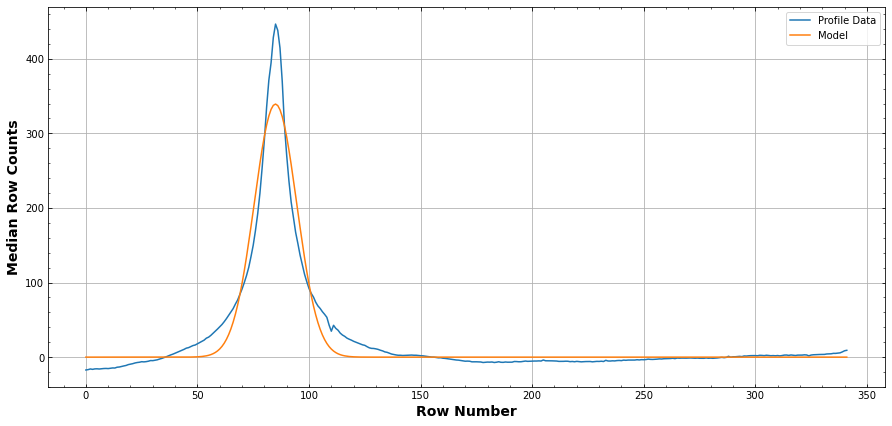

In [80]:
# Examine these fits by plotting the object profiles and overplotting the corresponding models
params = fmin(get_profile_chisq, guess, args=(ys, profile))
print("best fit parameters are", params)

model = get_profile_model(params, ys)
plt.plot(ys, profile, label='Profile Data')
plt.plot(ys, model, label='Model')
plt.xlabel('Row Number')
plt.ylabel('Median Row Counts')
plt.grid()
plt.legend();

In [81]:
# fit the profile centered at these columns
hwidth = 50
cols = np.arange(hwidth, nx + 1, 2 * hwidth)

ycenter = np.zeros( (len(cols), 2) )

for icol, col in enumerate(cols):
    stamp = (image - sky)[:, col - hwidth : col + hwidth]
    profile = np.mean(stamp, axis=1)
    params = fmin(get_profile_chisq, guess, args=(ys, profile))
    ycenter[icol, :] = params[[1, 2]]

Optimization terminated successfully.
         Current function value: 2.691720
         Iterations: 105
         Function evaluations: 191
Optimization terminated successfully.
         Current function value: 7.570960
         Iterations: 115
         Function evaluations: 209
Optimization terminated successfully.
         Current function value: 13.500894
         Iterations: 100
         Function evaluations: 181
Optimization terminated successfully.
         Current function value: 19.040658
         Iterations: 96
         Function evaluations: 172
Optimization terminated successfully.
         Current function value: 23.467875
         Iterations: 107
         Function evaluations: 192
Optimization terminated successfully.
         Current function value: 28.165562
         Iterations: 96
         Function evaluations: 175
Optimization terminated successfully.
         Current function value: 30.491069
         Iterations: 117
         Function evaluations: 216
Optimization term

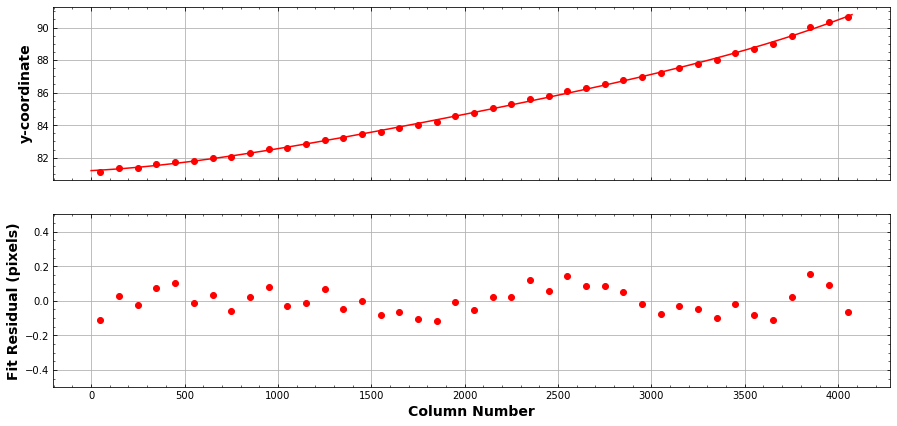

In [82]:
# fit the relation with a polynomial
ind = 0
t_order = 4 #determines shape of line
trace_c = np.polyfit(cols, ycenter[:, ind], t_order)
fig, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(cols, ycenter[:, ind], 'ro')
axarr[0].plot(xs, np.polyval(trace_c, xs), 'r')
axarr[0].axes.set_ylabel('y-coordinate'); axarr[0].grid();
axarr[1].plot(cols, ycenter[:, ind] - np.polyval(trace_c, cols), 'ro')
axarr[1].axes.set_ylim(-0.5, 0.5)
axarr[1].axes.set_ylabel('Fit Residual (pixels)')
plt.xlabel('Column Number'); axarr[1].grid();

Comment on whether the fit residuals are sufficiently small.
- The polynimal order minimum at 2 is needed for the line fit in the y-coordinate vs column number. Yet, I went with `t_order = 4` since the fit residual seems more order and fit within an area of +0.2 to -0.2.

### Step 5.2: Fit a spline to the target profile and generate a weight map.

In [83]:
# position offsets from the object trace (defined to be at slitpos = 0)
slitpos = yvals - np.polyval(trace_c, yvals)

# subtract the sky
nosky = image - sky

# normalize to the pixel brightness at the trace center
yinds = (np.round(np.polyval(trace_c, xs))).astype(int)
normed = nosky / nosky[yinds, xs] #nomralized to the values of the center of the trace

# get 1D arrays with the positions along the slit and the normalized counts
pos = slitpos.flatten()
counts = normed.flatten()

# sort by slit position
sort_inds = pos.argsort()
pos, counts = pos[sort_inds], counts[sort_inds]

# fit a spline to model the spatial profile
t = np.linspace(pos.min() + 2, pos.max() - 2, ny // 2) # spline knot points
profile_spl = LSQUnivariateSpline(pos, counts, t)

# remove outliers and re-fit
diff = counts - profile_spl(pos)
sample = sigma_clip(diff)
w = ((np.abs(diff) / sample.std()) < 5) & np.isfinite(diff)
profile_spl = LSQUnivariateSpline(pos[w], counts[w], t)

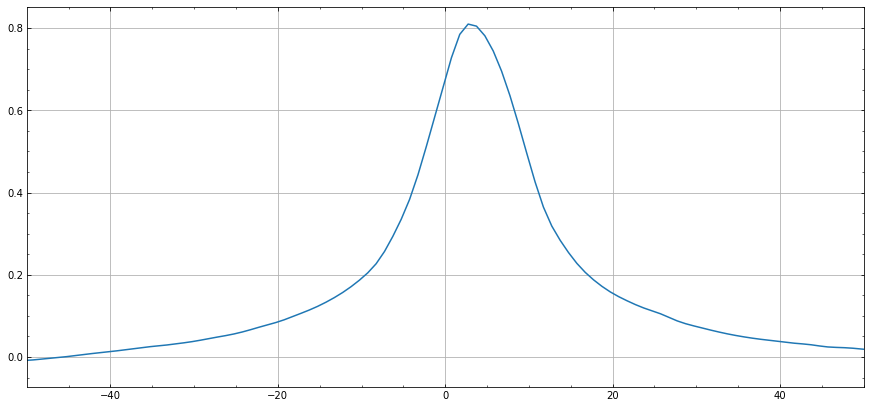

In [84]:
# plot the target profile
plt.plot(pos, profile_spl(pos) )
plt.xlim(-50, 50)
plt.grid();

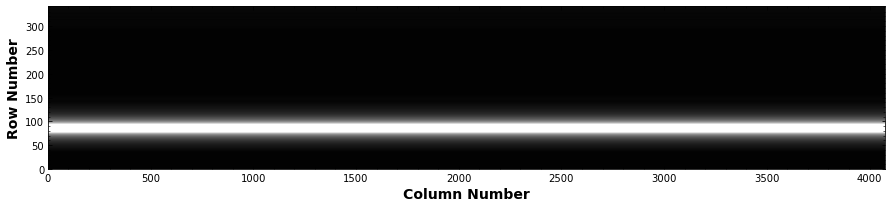

In [85]:
# create the profile image
profile_image = profile_spl(slitpos) #spline fit average over the entire image

# de-weight negative values in provile_image
profile_image[profile_image < 0] = 0

show_image(profile_image, upper=50)
#fake data/model of a map of the intensity of the target based on wavelength

In [ ]:
# Check on the effect of your outlier rejection by plotting your spline 
# model fits both before and after rejection


### Step 5.3: Extract the object's spectrum, and plot both your basic ("boxcar") extraction and your optimal extraction

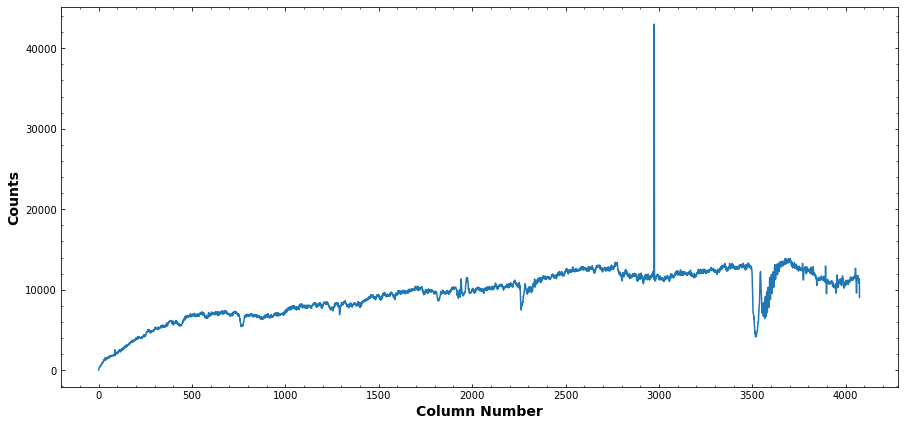

In [86]:
#basic version
# select which rows to sum
w = (slitpos > -50) & (slitpos < 50)
ymin, ymax = yvals[w].min(), yvals[w].max()

# calculate the sum
spec_basic = nosky[ymin:ymax, :].sum(axis=0)

# sky background
skybg_basic = sky[ymin:ymax, :].sum(axis=0)

# plot the extracted spectrum
plt.plot(xs, spec_basic)
plt.xlabel('Column Number')
plt.ylabel('Counts');

The truth array of the `slitpos` of the position offsets from the object trace is set to a range of -50 to 50 due to how large and bright the row area is of the target. And seem to be the way to get extract spectra flatten as possible. 

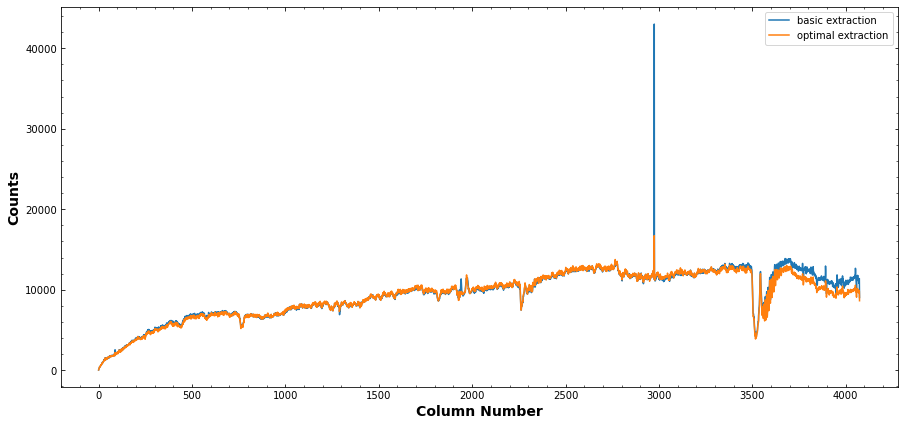

In [87]:
# calculate the weighted average (for each column)
spec_opt = (nosky * profile_image)[ymin:ymax, :].sum(axis=0) / profile_image.sum(axis=0)

# calculate the bias factor needed to scale the average to a sum
bias_factor = np.median(spec_basic / spec_opt)
spec_opt *= bias_factor

# same for the sky background
skybg_opt = (sky*profile_image)[ymin:ymax, :].sum(axis=0) / profile_image.sum(axis=0)
bias_factor_sky = np.median(skybg_basic / skybg_opt)
skybg_opt *= bias_factor_sky

# plot the extracted spectrum
plt.plot(xs, spec_basic, label='basic extraction')
plt.plot(xs, spec_opt, label='optimal extraction')
plt.xlabel('Column Number')
plt.ylabel('Counts')
plt.legend();

Choose a "clean", feature-free region of the spectrum that is relatively flat in slope.  How does the noise in this region compare in the basic vs. optimal extractions?  Does this make sense?


The base of the extraction spectra for both basic and optimal is curved. If a flat field of the 2-D Spectra was made, perhaps this could have fixed this. Most the extract spectra of both version seem to fit, yet the peak where the supposed H-alpha line of the target seems to be far smaller than the basic version.

## Step 6: Tweak the Wavelength Solution Using Sky Lines

Follow the procedure outlined in [Step 6 of the Guide to Long-Slit Spectral Extractions](../tutorials/spectra_guide.ipynb#step6) to correct the wavelengths for instrumental flexure. 

In [88]:
# re-extract lamp spectra using the profile_image
lamp_basic = lamp_image[ymin:ymax, :].mean(axis=0)
lamp_spec_opt = (lamp_image * profile_image)[ymin:ymax, :].sum(axis=0) / profile_image.sum(axis=0)
bias_factor = np.median(lamp_basic / lamp_spec_opt)
lamp_spec_opt *= bias_factor

# re-compute lamp_lines
lamp_lines_opt = get_lamp_lines(lamp_spec_opt)

found center pixel values for 51 lines


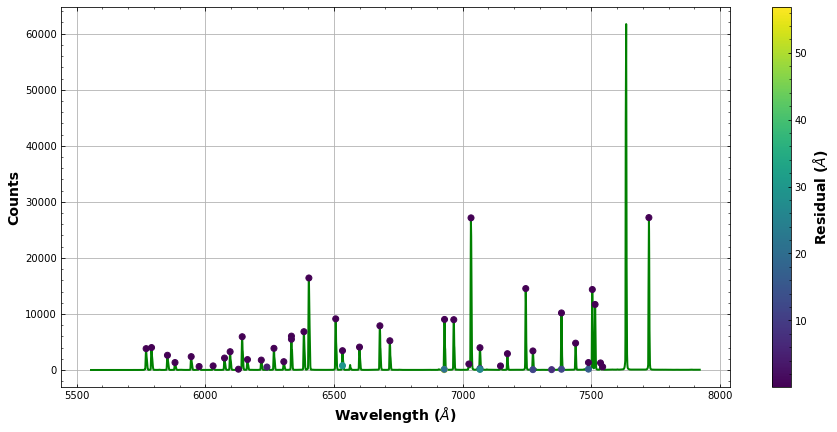

In [89]:
# use the old wavelength solution to identify lines
rough_waves = col_to_wav(coeff, lamp_lines_opt['x'])
lamp_lines_opt['wav'] = match_to_list(linelist['wav'], rough_waves)

# re-fit
coeff2, revcoeff2 = get_wavelength_solution(lamp_lines_opt, order=4)
check_wavelength_solution(lamp_spec_opt, lamp_lines_opt, coeff2)

STD of wavelength residual is 1.44 Angstrom


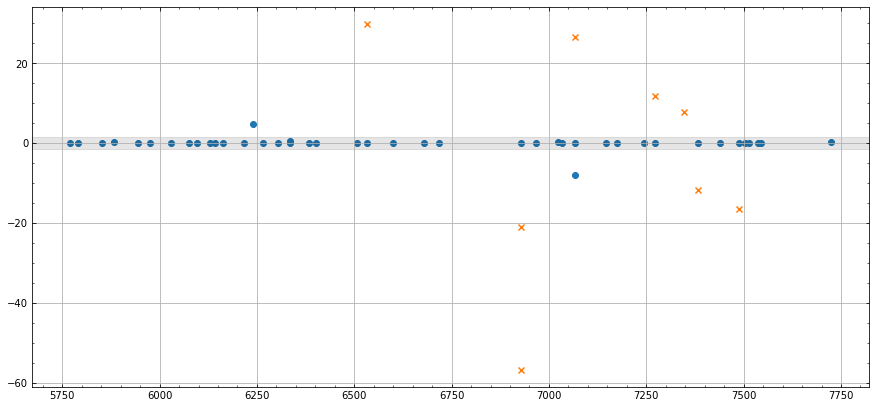

In [90]:
w = lamp_lines_opt['used']
plt.scatter(lamp_lines_opt['wav'][w], lamp_lines_opt['wavres'][w]) #, c=np.abs(lamp_lines['wavres'][w]))
plt.scatter(lamp_lines_opt['wav'][~w], lamp_lines_opt['wavres'][~w], marker='x') #c=np.abs(lamp_lines['wavres'][~w]))
plt.grid()

std = np.std(lamp_lines_opt['wavres'][w], ddof=1)
plt.axhspan(-std, std, color='k', alpha=0.1)
print(f'STD of wavelength residual is {std:0.3} Angstrom')

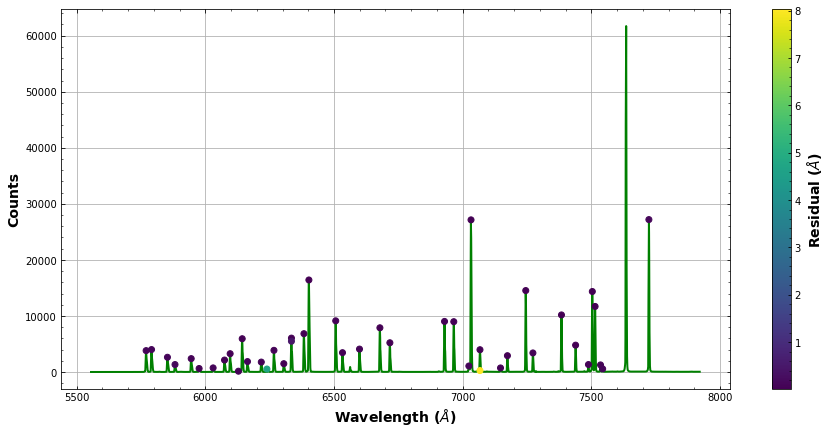

In [91]:
# you may need to exclude strong outliers and re-fit
coeff2, revcoeff2 = get_wavelength_solution(lamp_lines_opt[w], order=4)
check_wavelength_solution(lamp_spec_opt, lamp_lines_opt[w], coeff2)

In [92]:
# load skyline list
dtype = []
dtype.append( ('seq', int) )
dtype.append( ('wav', float) )
dtype.append( ('intensity', float) )
dtype.append( ('fwhm', float) )
dtype.append( ('flux', float) )

skylines = np.array([], dtype=dtype)
wildcard = os.path.join(basedir, 'UVES/', '*.dat')
fnames = glob(wildcard)
for fname in fnames:
    lines = np.genfromtxt(fname, dtype=dtype, skip_header=3, skip_footer=1)
    skylines = np.hstack([skylines, lines])
    
SKYLINES = skylines

In [93]:
# function to convert night sky linelist into spectral template
def model_sky(wav, *params):
    wavshift, scale, fwhm, conta, contb = params
    #wavshift is the wave shift, scale of Gaussain to line flux
    #fwhm is full-width half max, conta & contb lines to a continuum
    # start with the continuum
    model = np.polyval([conta, contb], wav)
    
    # add in each line
    sigma = fwhm / 2.355
    minwav = np.min(wav) - 3 * fwhm
    maxwav = np.max(wav) + 3 * fwhm
    w = ((SKYLINES['wav'] + wavshift) >= minwav) & ((SKYLINES['wav'] + wavshift) <= maxwav)
    for line in skylines[w]:
        # assume lines are Gaussian
        model += scale * line['flux'] * np.exp( -(wav - line['wav'] - wavshift) ** 2 / 2 / sigma ** 2)
        
    return model

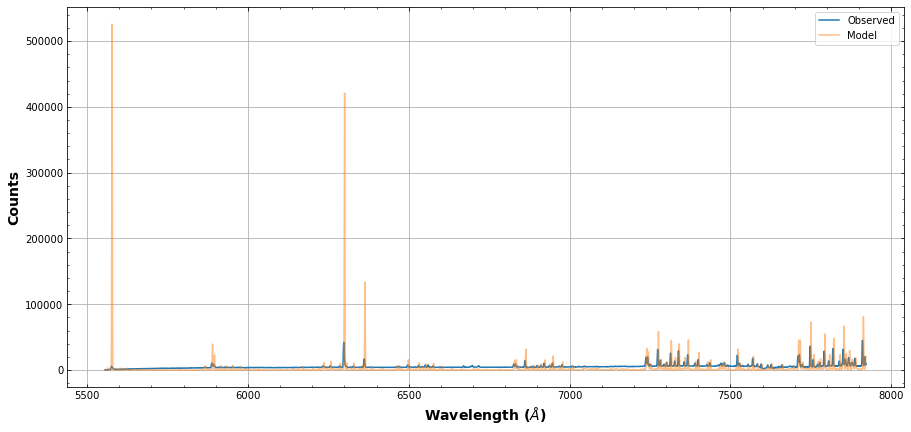

In [94]:
# get starting guess for the fwhm and flux scaling
wavs = col_to_wav(coeff2, np.arange(skybg_opt.size))
params = (0, 1, 2, 0, 0) 
skymodel = model_sky(wavs, *params)
w = skymodel > 1
scale = np.mean(skybg_opt[w] / skymodel[w]) 

plt.plot(wavs, skybg_opt, label='Observed') #blue graph
plt.plot(wavs, scale * skymodel, label='Model', alpha=0.5) #orange graph
plt.legend()
plt.grid()
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Counts');

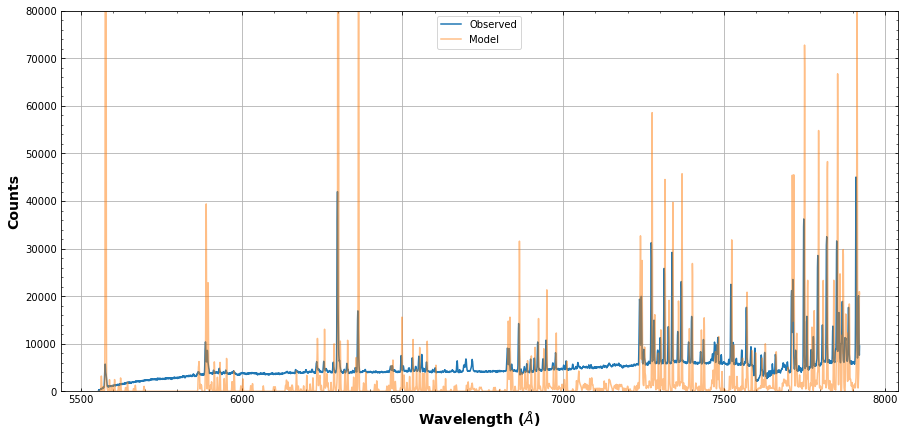

In [95]:
#zoom in
plt.plot(wavs, skybg_opt, label='Observed') #blue graph
plt.plot(wavs, scale * skymodel, label='Model', alpha=0.5) #orange graph
plt.legend()
plt.grid()
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Counts')
plt.ylim(0,80000);

Text(0, 0.5, 'Counts')

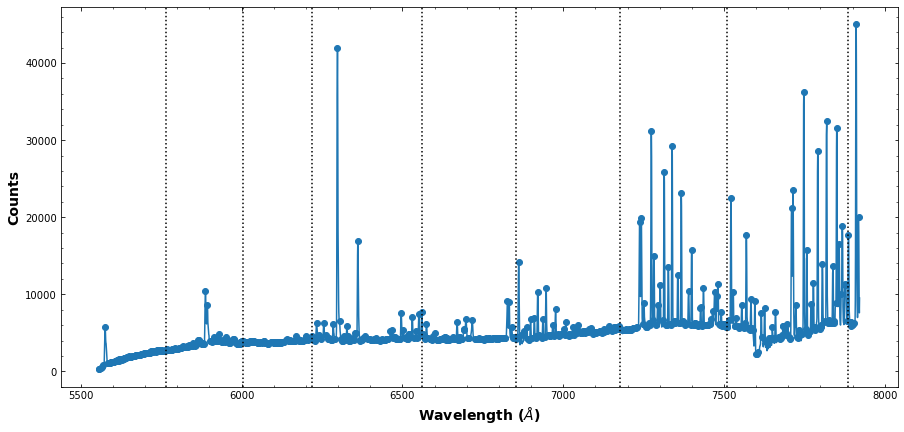

In [96]:
# locate observed sky line peaks (roughly)
skyline_cols, properties = find_peaks(skybg_opt, prominence=40)
skyline_wavs = col_to_wav(coeff2, skyline_cols)

plt.plot(wavs, skybg_opt, label='Observed')
plt.scatter(skyline_wavs, skybg_opt[skyline_cols]);

# divide into sections with at least a few lines
nmin = 100 #makes sure the nmin is large to at least 100 so the wavrange loop in the next cell doesn't crash
minwav = wavs.min()
wavranges = []
while (skyline_wavs > minwav).sum() > nmin:
    w = skyline_wavs > minwav
    maxwav = skyline_wavs[w][nmin - 1]
    dwav = (maxwav - minwav) / 2
    wavranges.append([minwav - dwav, maxwav + dwav])    
    plt.axvline(maxwav, color='k', ls='dotted')
    minwav = maxwav
wavranges.append([maxwav, wavs.max()])
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Counts')

In [101]:
# fit for the wavelength shift section by section
dtype = []
dtype.append( ('cwav', float) )
dtype.append( ('wavshift', float) )
dtype.append( ('wavshift_err', float) )
dtype.append( ('scale', float) )
dtype.append( ('scale_err', float) )
dtype.append( ('fwhm', float) )
dtype.append( ('fwhm_err', float) )

guess = 0, scale, 5, 0, 0
results = []

for wavrange in wavranges:
    minwav, maxwav = wavrange
    w = (wavs >= minwav) & (wavs < maxwav)
    bounds = ((-50, 0, 0, -np.inf, -np.inf), (50, np.inf, np.inf, np.inf, np.inf))
    popt, pcov = curve_fit(model_sky, wavs[w], skybg_opt[w], p0=guess, bounds=bounds)
    cols = [(minwav + maxwav) / 2]
    for i in range(3):
        cols.append(popt[i])
        cols.append(np.sqrt(np.diag(pcov)[i]))
        
    newrow = np.array(tuple(cols), dtype=dtype)
    results.append(newrow)
results = np.array(results)

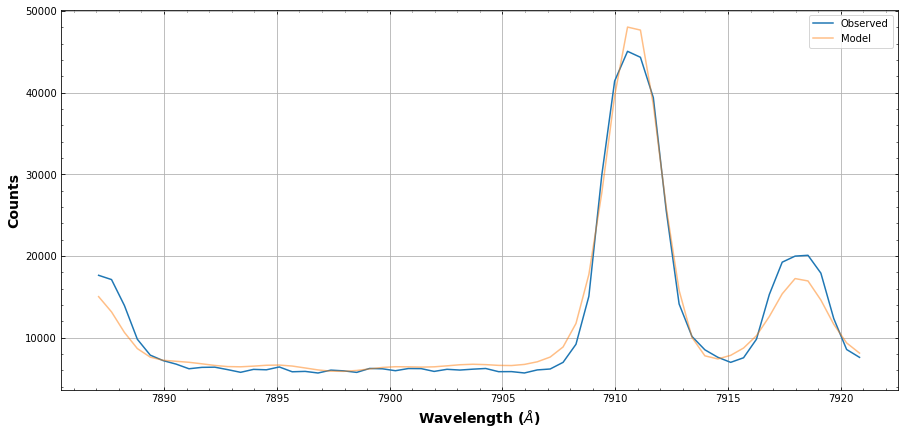

In [102]:
# check the last wavelength range fit
model = model_sky(wavs, *popt)
plt.plot(wavs[w], skybg_opt[w], label='Observed')
plt.plot(wavs[w], model[w], label='Model', alpha=0.5)
plt.legend(); plt.grid()
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Counts');

Fit a polynomial to the measured wavelength shifts in order to interpolate the results to any wavelength. 

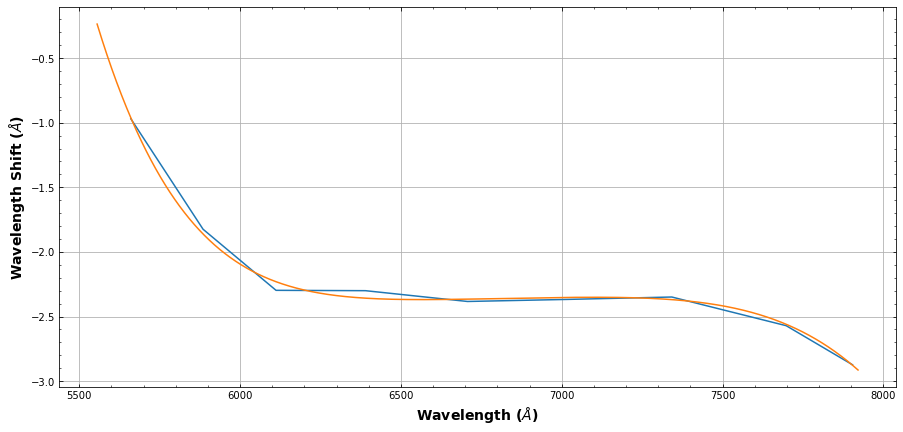

In [103]:
# fit for the wavelength offset
cwavshift = np.polyfit(results['cwav'], results['wavshift'], 6) #6 is reasonable order for fit
plt.plot(results['cwav'], results['wavshift'])
plt.plot(wavs, np.polyval(cwavshift, wavs))
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Wavelength Shift ($\AA$)')
plt.grid()

# correct wavelengths to match skyline values
wavs_corr = wavs - np.polyval(cwavshift, wavs)

Fit for the instrumental resolving power as a function of wavelength, $R(\lambda) = \lambda / \delta\lambda$.

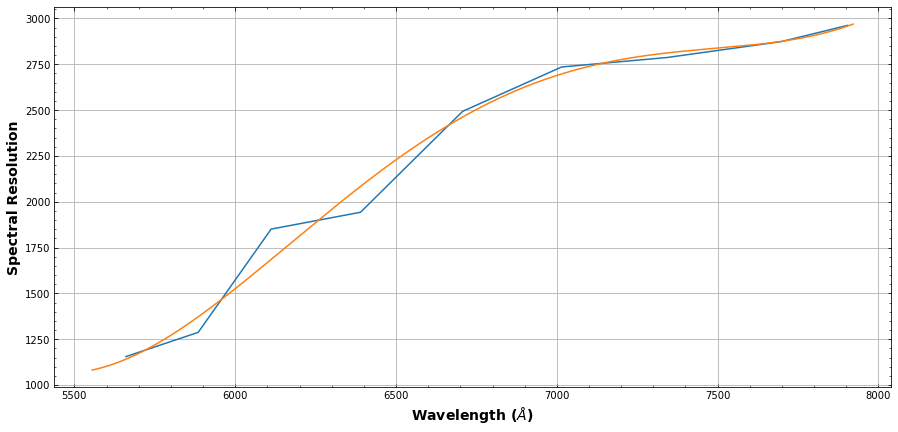

In [104]:
# fit for the resolving power (lambda / fwhm)
cres = np.polyfit(results['cwav'], results['cwav'] / results['fwhm'], 4)
plt.plot(results['cwav'], results['cwav'] / results['fwhm'])
plt.plot(wavs, np.polyval(cres, wavs))
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Spectral Resolution')
plt.grid()

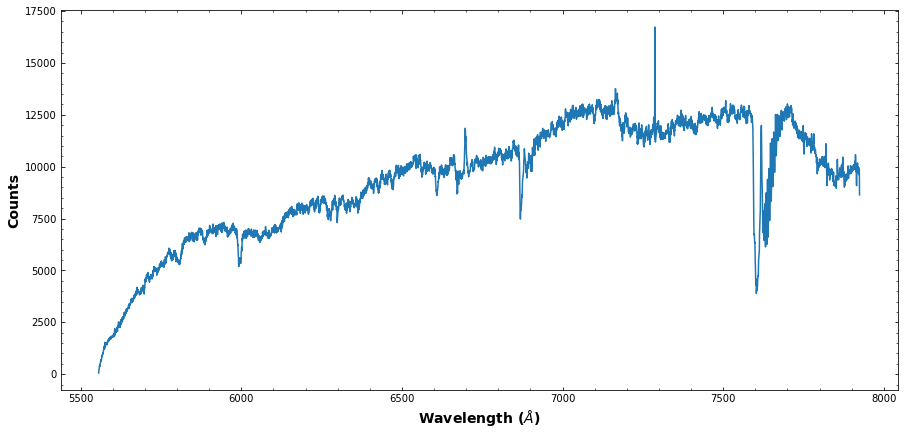

In [105]:
# apply the wavelength solution to the extracted spectrum
plt.plot(wavs_corr, spec_opt);
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Counts');

 The extracted spectrum looks similar to the previous version in which what it appears when `w = (slitpos > -10) & (slitpos < 10)`. The curved noise is likely due to the host galaxy in which the supernova resides in. 

- Include an examination of the spectral resolution of your data.  
- What is the FWHM of the resolution element as a function of wavelength, in km/s?


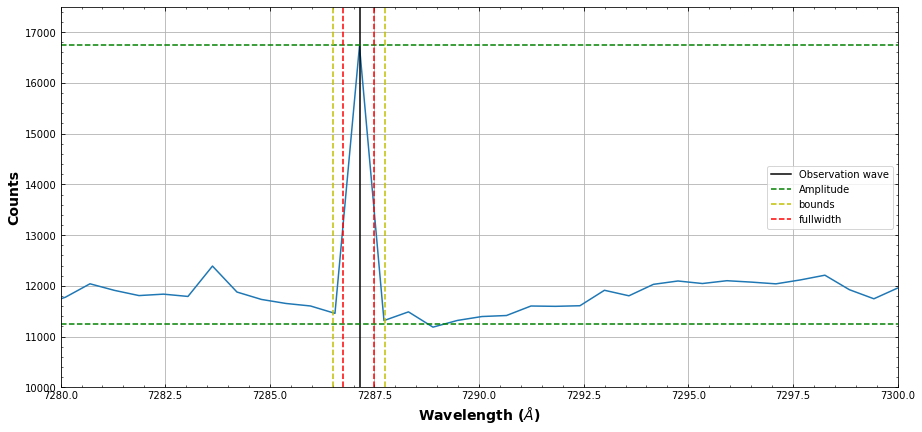

In [106]:
# plot the spectra
plt.plot(wavs_corr, spec_opt);

#zoom in on H-alpha
plt.xlim(7280, 7300) 
plt.ylim(10000, 17500)
plt.grid()

#make a guess at the central wavelength
obswav_guess = 7287.15 
plt.axvline(obswav_guess, ls='solid', c='k', label='Observation wave')

#amplitude
plt.axhline(11250, ls='dashed', c='g', label='Amplitude')
plt.axhline(16750, ls='dashed', c='g') #amplitude = 16750-11250=5500

#bounds
plt.axvline(7286.5, ls='dashed', c='y', label='bounds')
plt.axvline(7287.75, ls='dashed', c='y')

#fullwidth
plt.axvline(7286.75, ls='dashed', c='r', label='fullwidth')
plt.axvline(7287.5, ls='dashed', c='r') #fullwidth is 0.75, halfwidth/sigma is 0.375
plt.legend()
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Counts');

Based on the plot shown of the residual wavelength. The FWHM is around 0.75.

## Step 7: Flux Calibration (Optional)

This step is optional, but you can follow the procedure outlined in [Step 7 of the Guide to Long-Slit Spectral Extractions](../tutorials/spectra_guide.ipynb#step7) to flux calibrate the extracted spectra.

## Step 8: Removal of Telluric Features (Optional)

This step is optional, but you can follow the procedure outlined in [Step 8 of the Guide to Long-Slit Spectral Extractions](../tutorials/spectra_guide.ipynb#step8) to remove telluric features from the spectra.

## Step 9: Measure the Galaxy Redshift

### Step 9.0: Use emission-line modeling.  

You can use the simple Gaussian model (plus a constant value for the continuum) provided below to model the emission lines, or you can use a more advanced emission line model. 

In [107]:
# model spectral lines
def simple_model(x, *params):
    amp, x0, sigma, const = params
    return amp * np.exp(-(x - x0)**2 / 2 / sigma**2) + const

In [108]:
#look at quiz 18
guess = (5500, 7287.15, 0.375) #amp, x0, sigma
bounds = ((0, 7286.5, 0), (np.inf, 7287.75, np.inf)) #np.inf is infinity
popt, pcov = curve_fit(gaussian, wavs_corr, spec_opt, p0=guess, bounds=bounds)

obswav = popt[1]
obswav_error = np.sqrt(pcov[1, 1])
print(f'Observed wavelength of H-alpha is {obswav:.3f} +/- {obswav_error:.3f}')

Observed wavelength of H-alpha is 7286.500 +/- 6.442


In [109]:
restwav = 6562.78 #H-alpha rest wavelength
std = 0.1656 # standard deviation of lamp wavelength residuals
redshift = (obswav - restwav)/restwav # or (obswav / restwav) - 1
redshift_error = np.hypot(obswav_error, std) /restwav #np.hypot is the hypotenuse
print(f'The redshift is {redshift:.5f} +/- {redshift_error:.5f}')

The redshift is 0.11028 +/- 0.00098


### Step 9.1: Use cross-correlation with a galaxy spectral template.

The file `spDR2-027.fit` (in this repo) contains the spectrum of a star-forming galaxy from this set of [SDSS spectral templates](http://classic.sdss.org/dr5/algorithms/spectemplates/).  Cross-correlate this spectrum with your galaxy target to determine its redshift.

In [130]:
# Read in template
template_flx = fits.getdata('spDR2-027.fit')[0,:]
head = fits.getheader('spDR2-027.fit')
template_wav = 10**(head['crval1'] + head['cd1_1']*np.arange(template_flx.size))

# You'll also need to convert your target's wavelength array to vacuum wavelengths, 
# as the template is in vacuum (as are all SDSS spectra)
from PyAstronomy import pyasl
wavs_corr_vac = pyasl.airtovac2(wavs_corr)

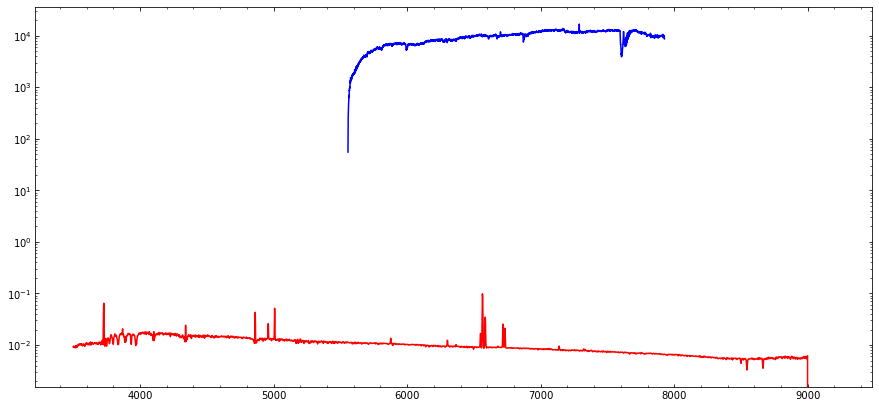

In [135]:
plt.plot(wavs_corr_vac, spec_opt, c='b')
plt.plot(template_wav, template_flx, c='r')
plt.yscale('log')

Based on the maximum value of the cross-correlation, the radial velocity is at 24999.5 km/s.


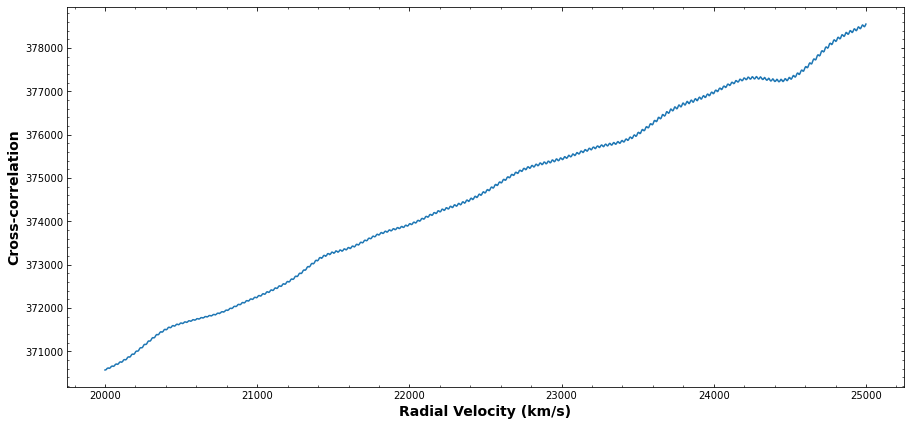

In [136]:
# Cross-correlate, look at quiz 17
rv, cc = pyasl.crosscorrRV(wavs_corr_vac, spec_opt, template_wav, template_flx, 20000., 25000., (22500/5000))
plt.plot(rv, cc)
plt.xlabel('Radial Velocity (km/s)')
plt.ylabel('Cross-correlation')
maxcc= np.argmax(cc)
print("Based on the maximum value of the cross-correlation, the radial velocity is at {0:.1f} km/s.".format(rv[maxcc]))
# How does this result compare to that obtained from your emission-line modeling?

Based on the maximum value of the cross-correlation, the radial velocity is at 8998.0 km/s.


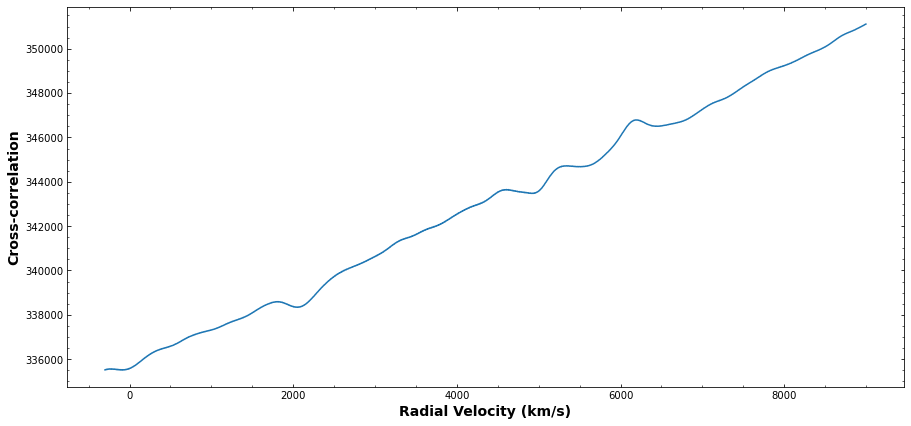

In [138]:
# Cross-correlate, look at quiz 17
rv, cc = pyasl.crosscorrRV(wavs_corr_vac, spec_opt, template_wav, template_flx, -300., 9000., 2.0)
plt.plot(rv, cc)
plt.xlabel('Radial Velocity (km/s)')
plt.ylabel('Cross-correlation')
maxcc= np.argmax(cc)
print("Based on the maximum value of the cross-correlation, the radial velocity is at {0:.1f} km/s.".format(rv[maxcc]))
# How does this result compare to that obtained from your emission-line modeling?

Links on information on 2006eb:
- https://www.wis-tns.org/object/2006eb
- https://ui.adsabs.harvard.edu/abs/2006CBET..590....1Q/abstract

Using information on how the redshift is measure through radial velocity. $z \approx \frac{v}{c}$
 - ref: https://astronomy.swin.edu.au/cosmos/c/cosmological+redshift

In [139]:
c = 299792 #km/s of the speed of light
z = rv[maxcc]/c
print("Redshift of SN 2006eb's host galaxy, UGC 771, is {0:.5f}.".format(z))

Redshift of SN 2006eb's host galaxy, UGC 771, is 0.03001.


This seems to be higher than the SLOAN Digital Sky Survey recorded at a redshift of 0.01717 $\pm$ 0.00001. 
- ref: http://simbad.u-strasbg.fr/simbad/sim-id?Ident=UGC+++771
- https://ui.adsabs.harvard.edu/abs/2006CBET..590....1Q/abstract